# Regression under additive noise assumption

Minimisation of mean square error is standard way to build regression models. This corresponds to deterministic dependence $y=f(x)$ that is slightly spoiled by additive Gaussian noise. However, nothing guarantees that the noise is additive or it is Gaussian at all. 

The minimisation of means squared error is guaranteed to reveal the true relation $y=f(x)$ if the followin conditions are satisfied:
* The model can represent the true relation $y=f(x)$.
* The assumption about additive Gaussian noise is true and individual errors are independent.   
* There is enough observations $(x_1, y_1),\ldots, (x_n, y_n)$ to cancel out random fluctuations.

It is really hard to estimate the number of samples. However, if such converge occurs then the prediction $\hat{y}(x)\approx f(x)$ and thus residuals $r_i=y_i-\hat{y}_i$ must follow normal distribution up to a small approximation error. By drawing the histogram of residuals and finding the bet fitted normal distribution we can easy check if all three assumptions are satisfied.  

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import arange
from pandas import read_csv
from pandas import DataFrame

from scipy.stats import norm
from scipy.stats import laplace

from sklearn.linear_model import LinearRegression

from IPython.display import Math
from convenience import mdisplay

from plotnine import *
from plotnine import options as pl9_options
pl9_options.figure_size = (15, 7)

## I. Insufficiency of Ordinary Least Squares Regression 

Let us consider a regression task where we know from physical considerations that $y=\alpha x^2 +\beta$. To solve this task, we use input transformation $z=x^2$ to reduce it to linear regression task we can solve with standard methods. To complete the analysis, we analyse the distribution of residues $y_i-\hat{y}_i$ to see whether the assumption about additive Gaussian noise is satisfied:
\begin{align*}
y_i=\alpha x_i^2 +\beta + \varepsilon_i,\qquad\text{for}\qquad \varepsilon_i\sim\mathcal{N}(0,\sigma)\enspace.
\end{align*}

Regression data 
 
 
 $x^0$ 
 $x^1$ 
 $x^2$ 
 $y$ 
 
 
 
 
 1 
 0.728269 
 0.530376 
 0.512820 
 
 
 1 
 0.909930 
 0.827973 
 0.820282 
 
 
 1 
 0.380931 
 0.145108 
 0.250688 
 
 
 1 
 0.245030 
 0.060040 
 0.153003 
 
 
 1 
 0.626321 
 0.392278 
 0.156423

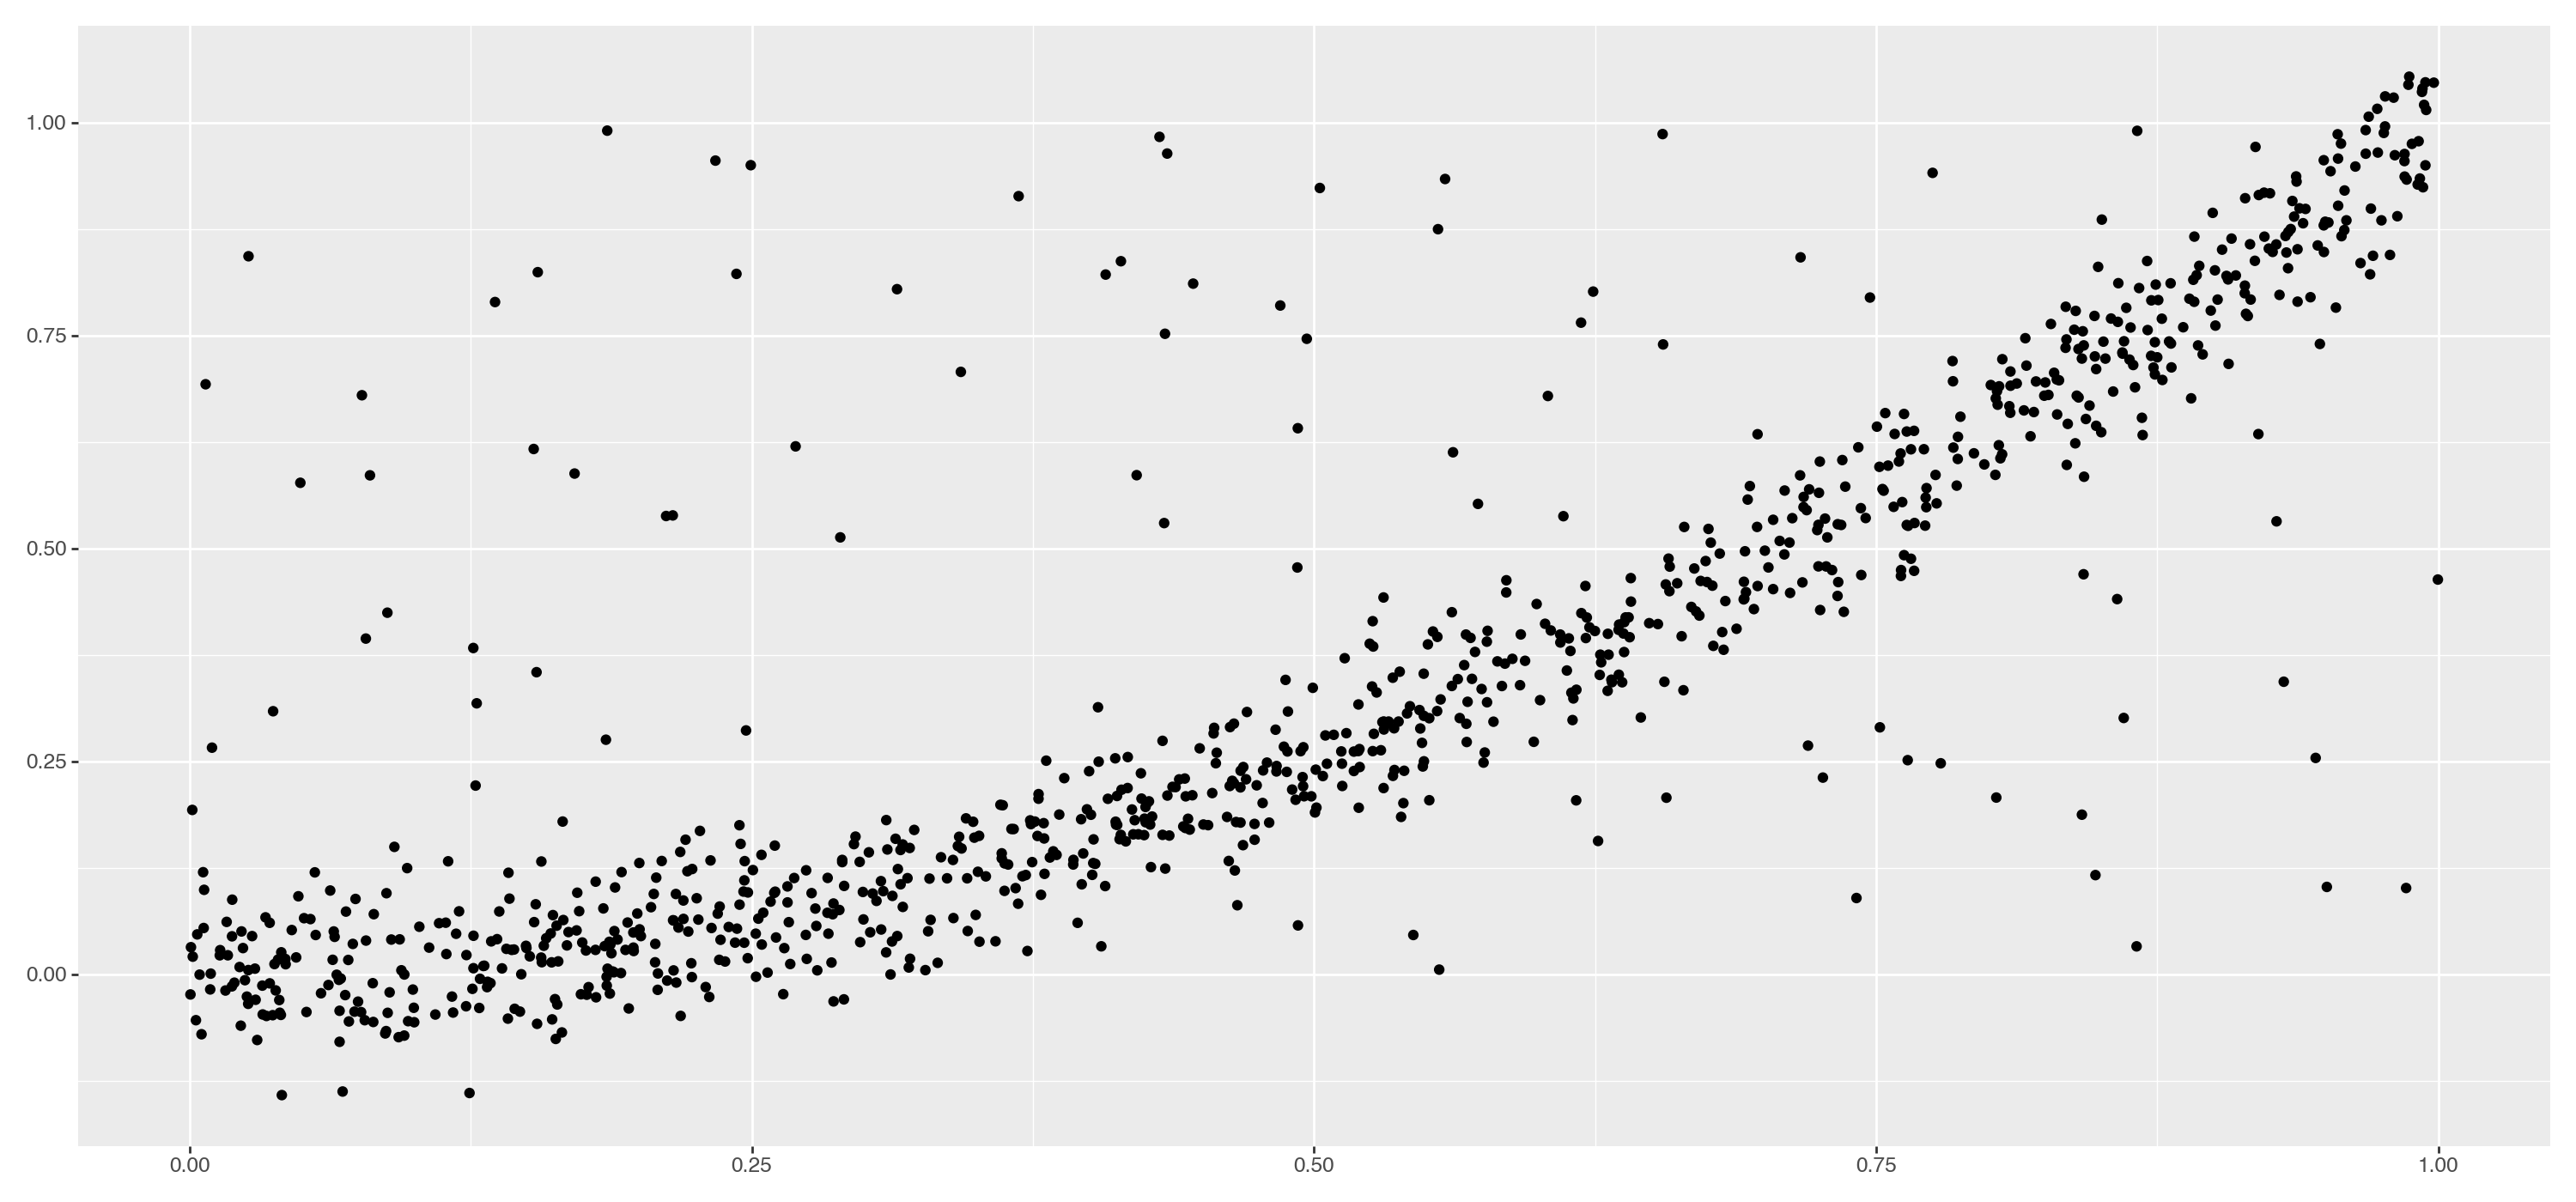

In [28]:
df = read_csv('data/regression_benchmark.csv').rename(columns={'x': '$x^1$', 'y': '$y$'})
df['$x^2$'] = df['$x^1$']**2
df['$x^0$'] = 1
df = df[['$x^0$', '$x^1$', '$x^2$', '$y$']]
mdisplay([df.head()], ['Regression data'])

p = ggplot(df) + geom_point(aes(x='$x^1$', y='$y$'))+ xlab('') + ylab('')
display(p)

# p.save('regression_challenge.pdf', path='results', height=6, width=12, verbose=False)

Let us convert this into a univariate linear regression task and solve it with ordinary least squares method.

Altered feature space 
 
 
 $x^2$ 
 $x^0$ 
 
 
 
 
 0.530376 
 1 
 
 
 0.827973 
 1 
 
 
 0.145108 
 1 
 
 
 0.060040 
 1 
 
 
 0.392278 
 1

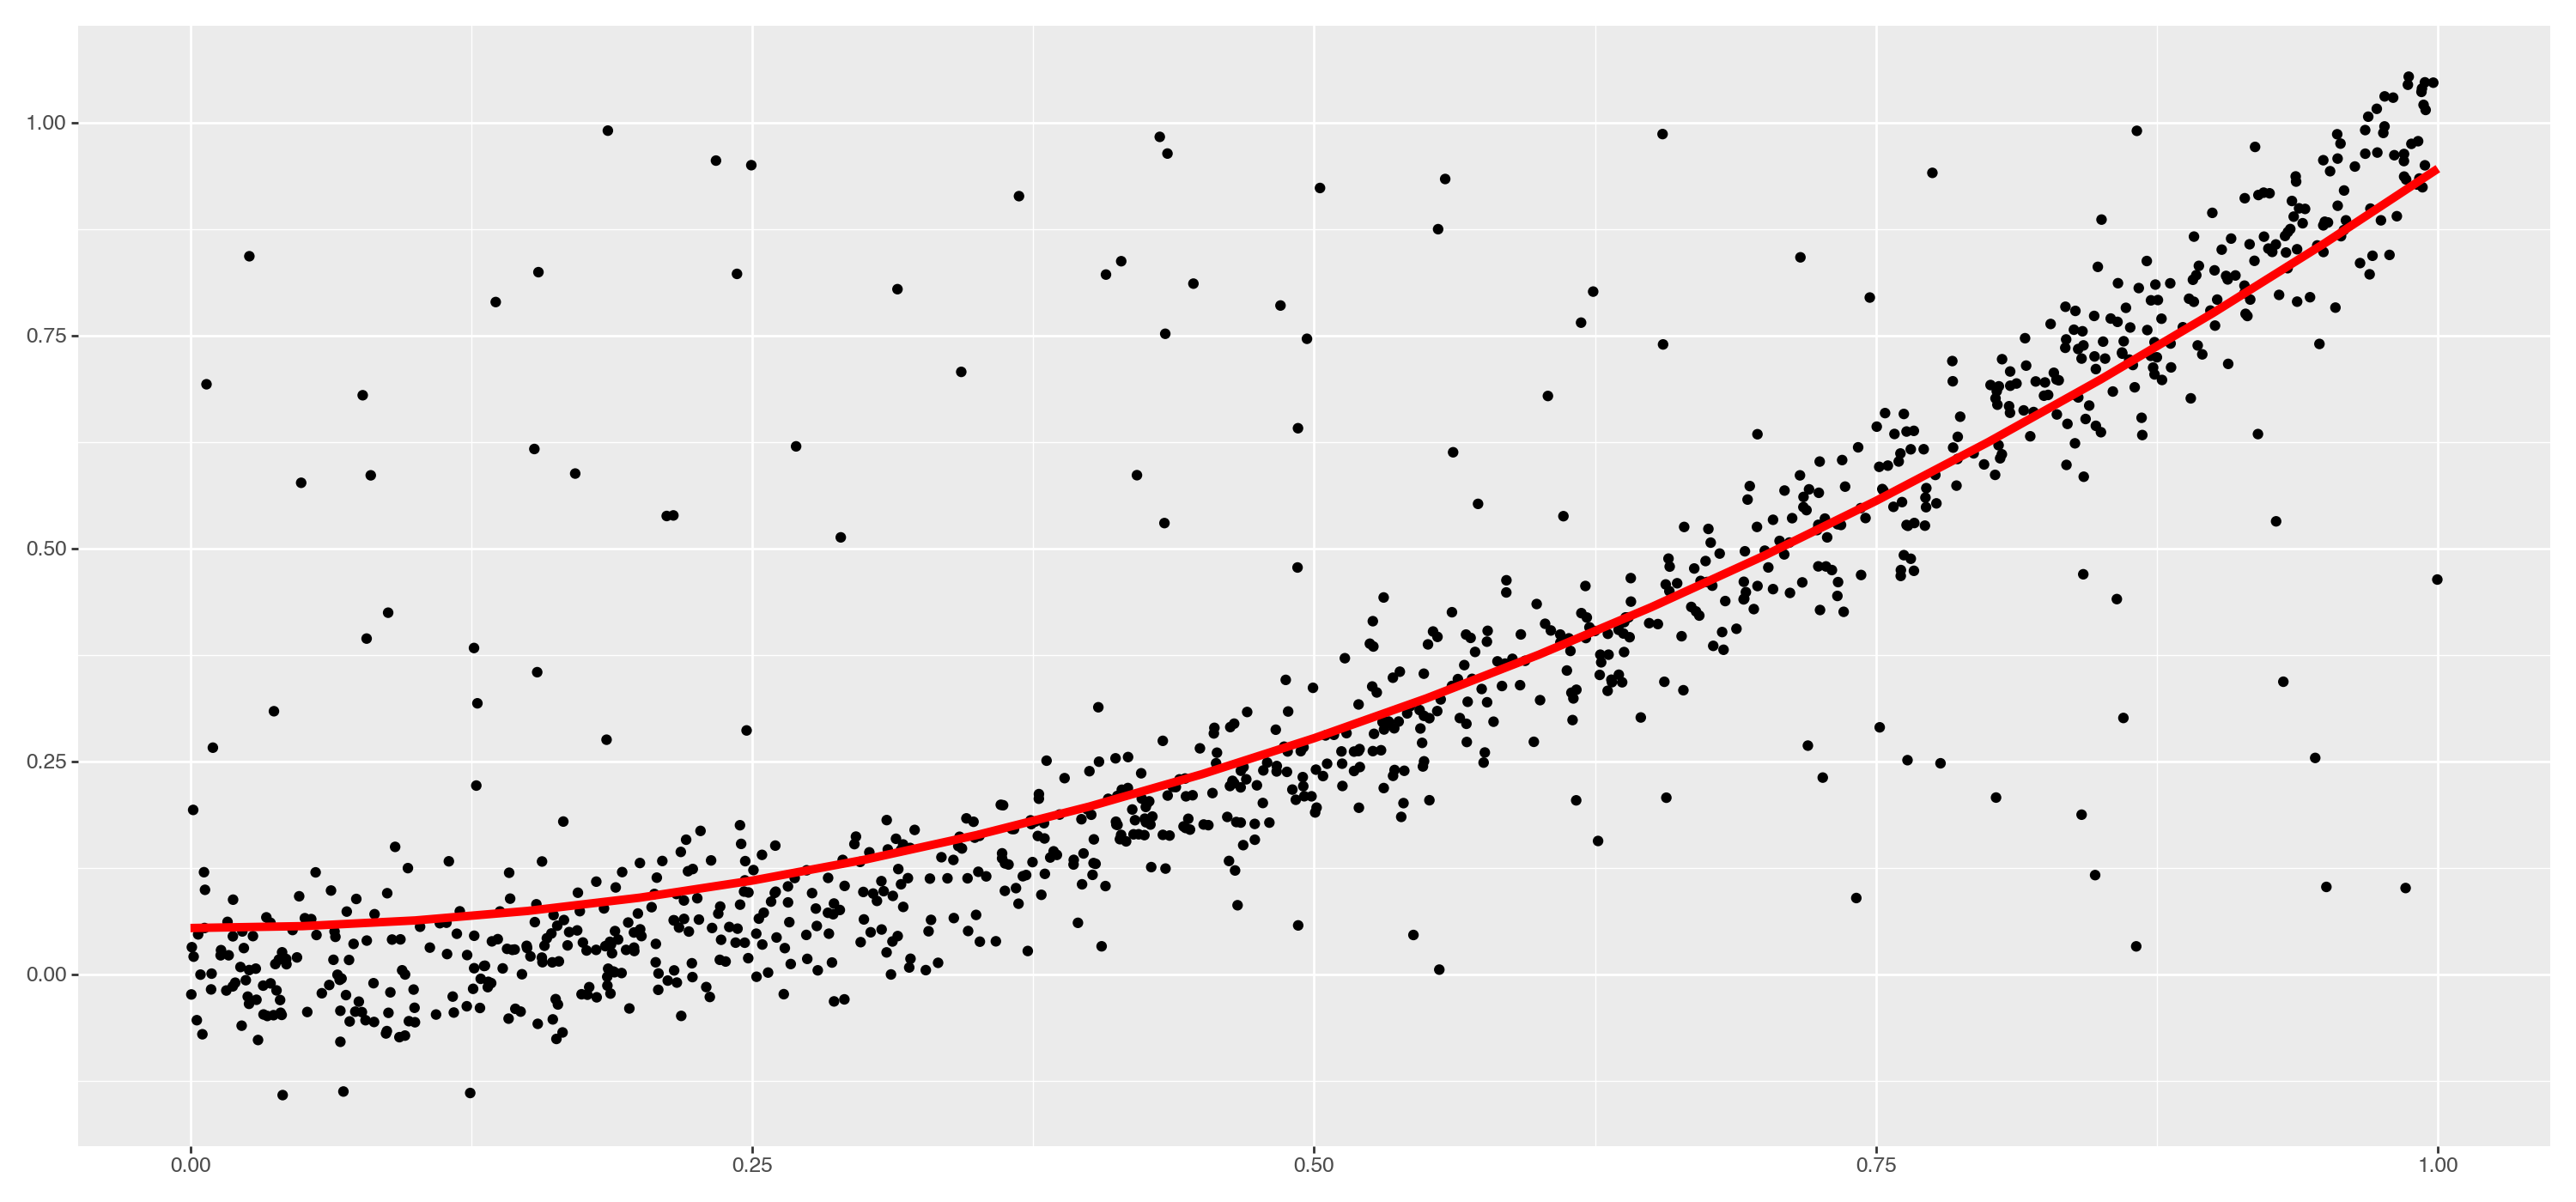

In [11]:
# Altered feature space
X = df[['$x^2$', '$x^0$']]
mdisplay([X.head()], ['Altered feature space'])

# Fit a model 
lm = LinearRegression(fit_intercept=False)
lm.fit(X, df['$y$'])
alpha, beta = lm.coef_

# Compute prediction line
dm = DataFrame({'x':arange(0, 1.05, 0.05)})
dm['y'] = alpha * dm['x']**2 + beta

# Show the corresponding graph 
p  = ggplot(df) + geom_point(aes(x='$x^1$', y='$y$'))+ xlab('') + ylab('') 
p += geom_line(aes(x='x', y='y'), data=dm, color='red', size=2)
p += labs(x="", y='')
display(p)
# p.save('naive_fit.pdf', path='results', height=6, width=12, verbose=False)

Let us now do diagnostics on residuals to see if desired assumptions really hold.

In [12]:
y_pred = lm.predict(X)
residuals = DataFrame({'residuals': df['$y$'] - y_pred})

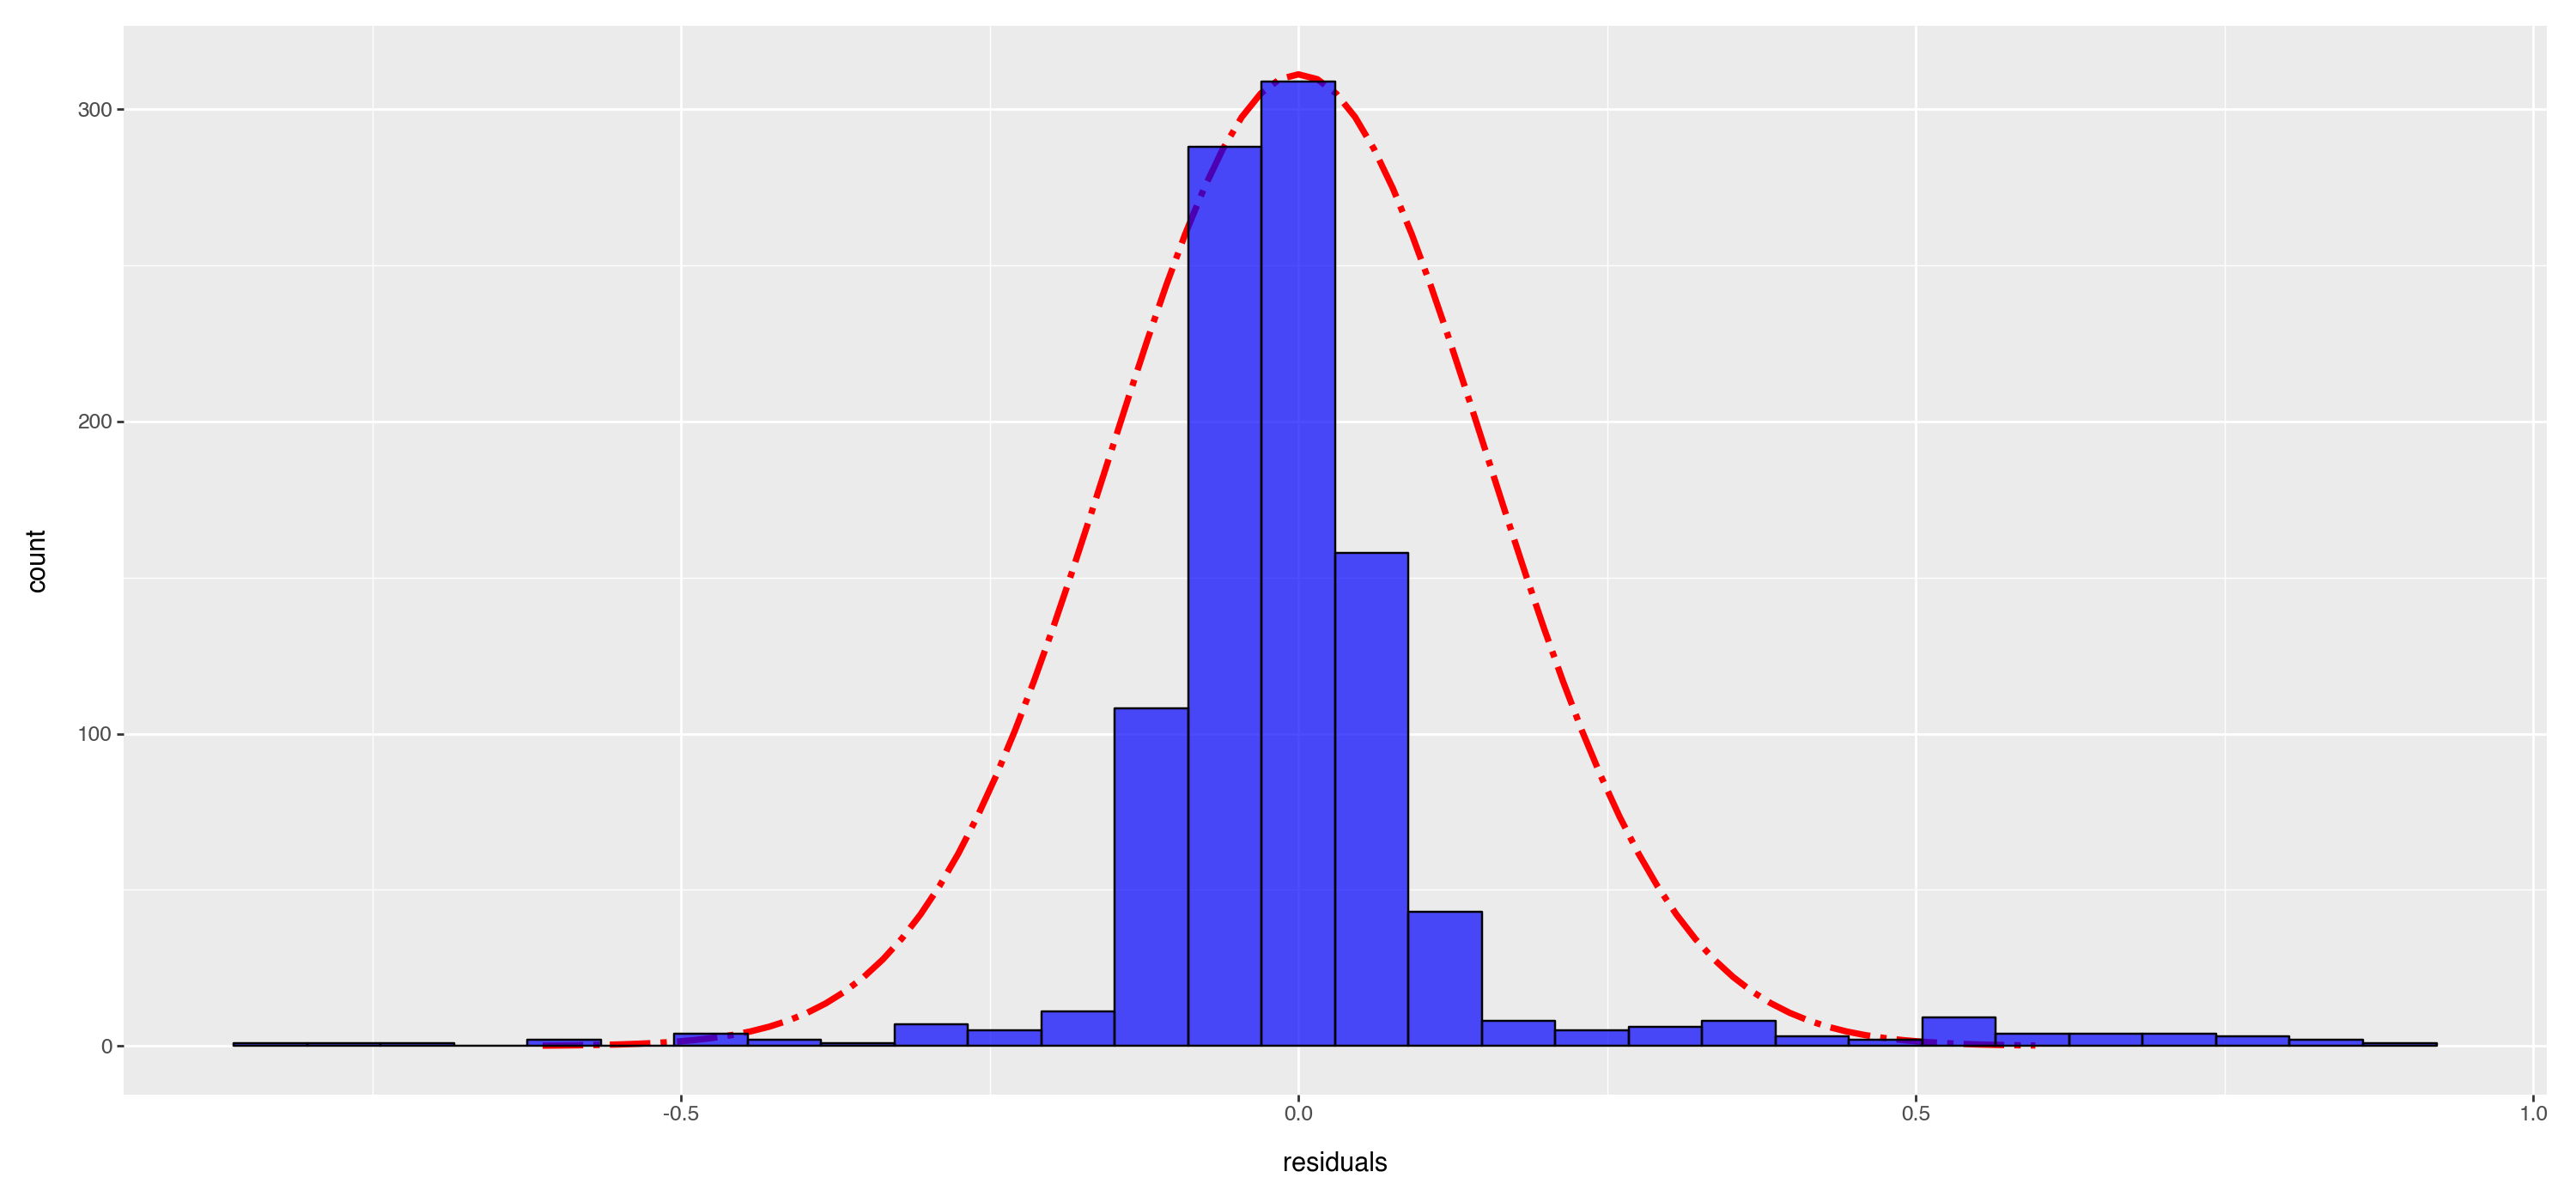

In [13]:
mu = residuals['residuals'].mean()
sigma = residuals['residuals'].std()

ndf = DataFrame({'x': arange(-4*sigma, 4*sigma, sigma/10)})
ndf['p'] = norm.pdf(ndf['x'], loc=mu, scale=sigma)
ndf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7.8 # Use Tambov constant to align graphs

p = ggplot(residuals) 
p += geom_line(aes(x='x', y='h'), data=ndf, color='red', size=1.5, linetype='dashdot')
p += geom_histogram(aes(x='residuals'), bins=30, fill="blue", color="black", alpha=0.7)
p += labs(x="residuals", y='count')
display(p)
# p.save('naive_fit_residuals.pdf', path='results', height=6, width=12, verbose=False)


Let us check if Laplace distribution as an additive error fits better on the data.

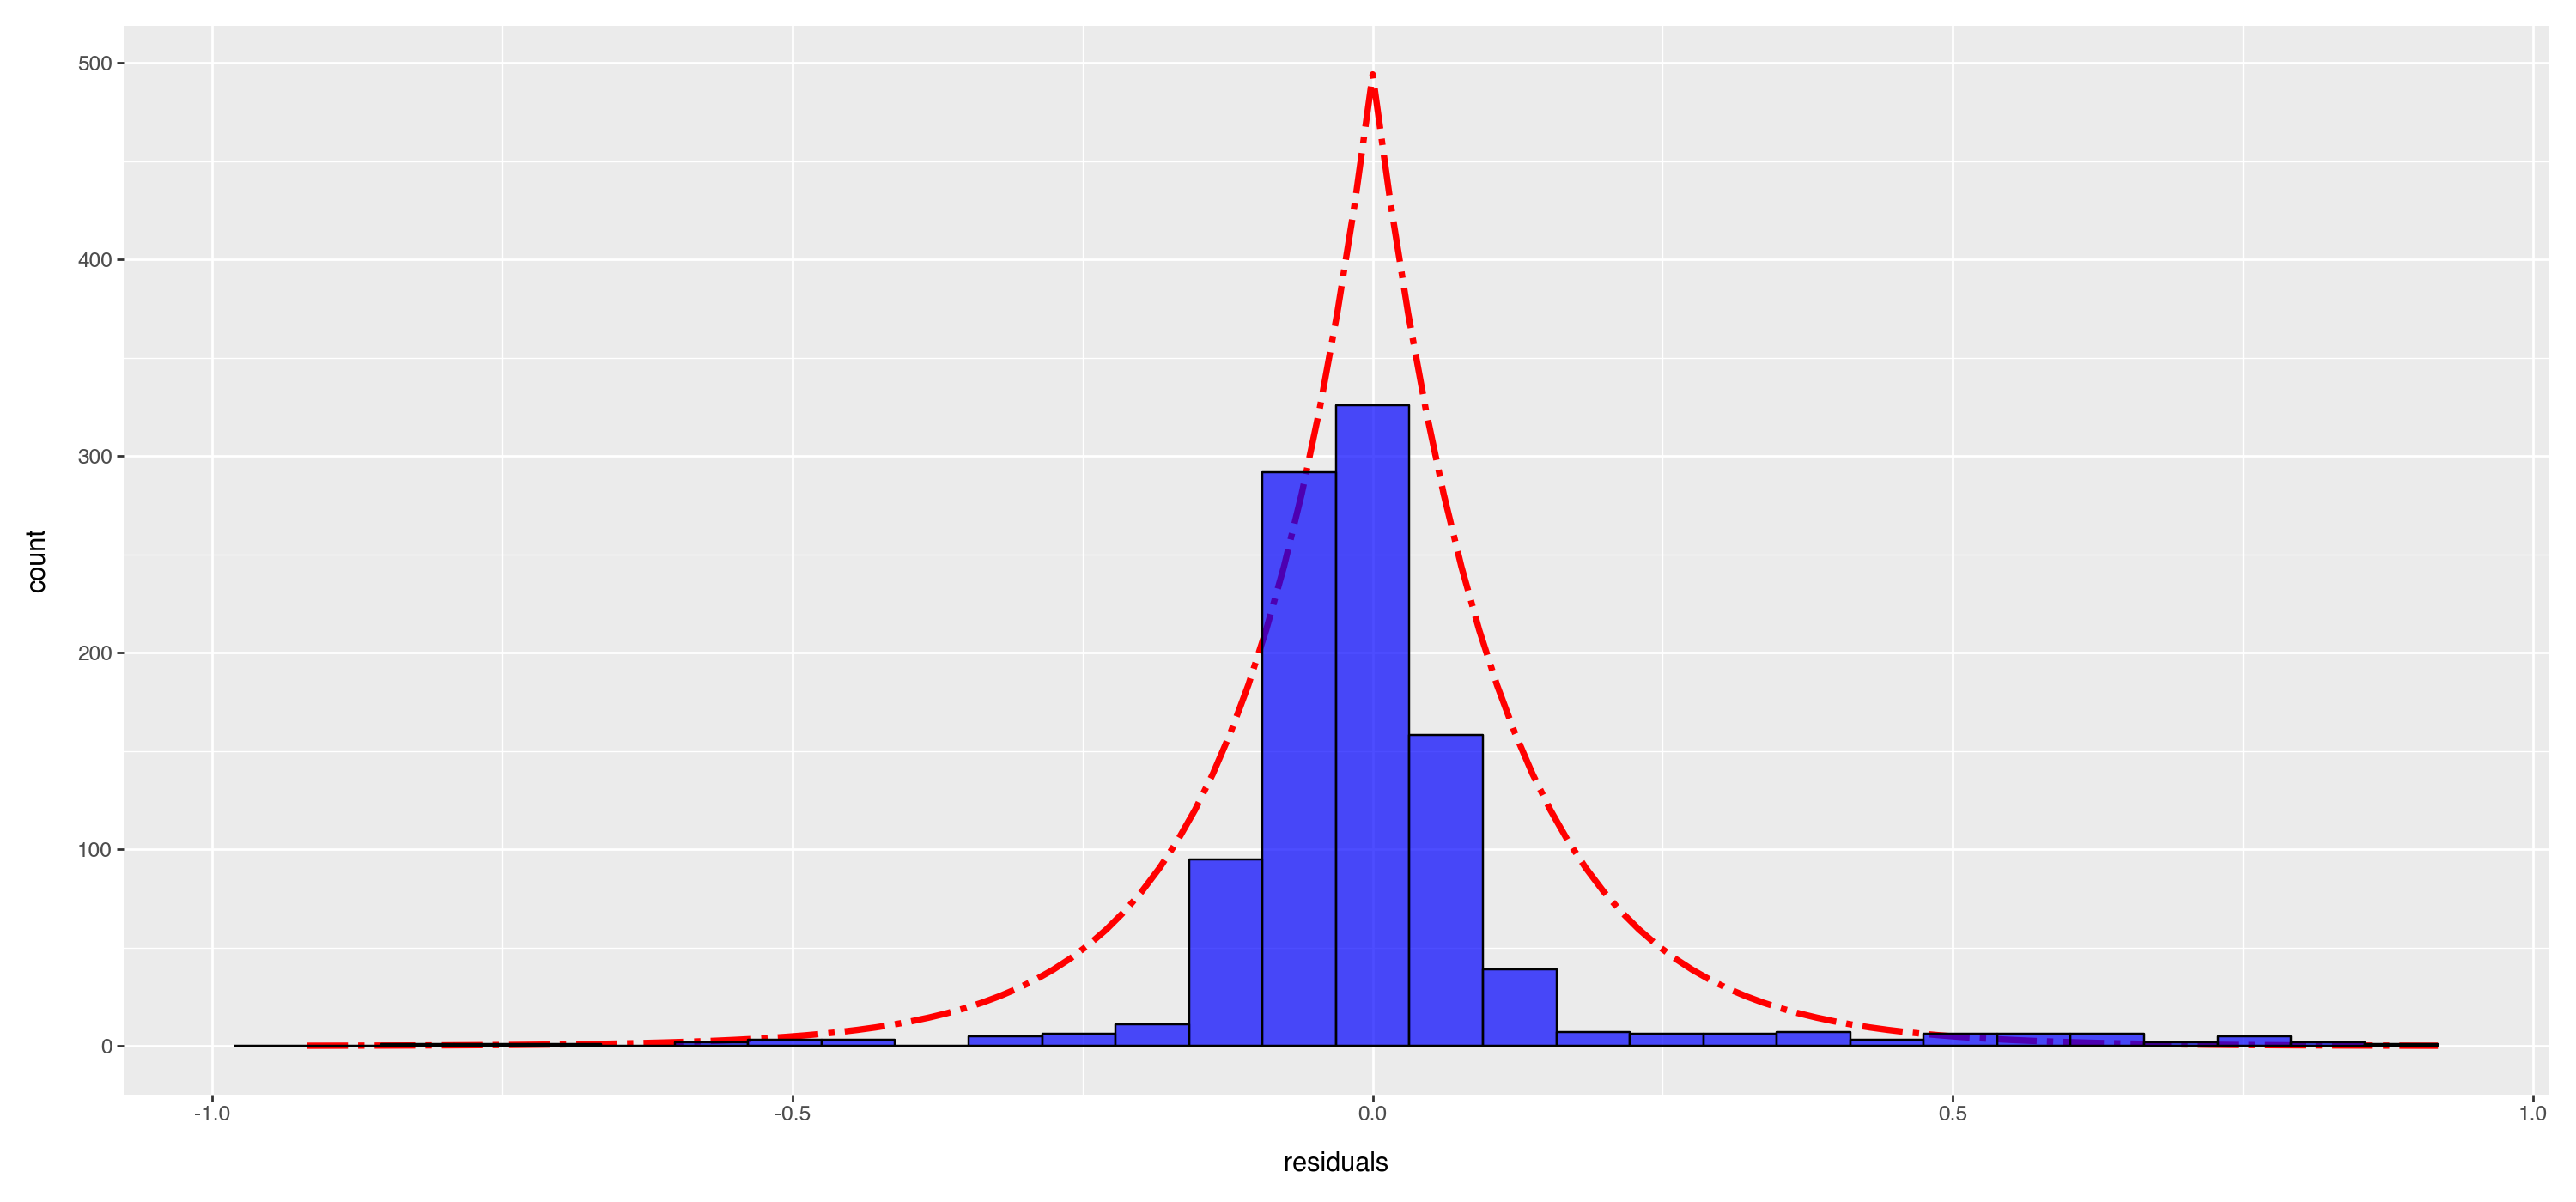

In [14]:
ndf = DataFrame({'x': arange(-6*sigma, 6*sigma, sigma/10)})
# use moment matching to find good parameters for Laplace distribution
ndf['p'] = laplace.pdf(ndf['x'], loc=mu, scale=1/np.sqrt(2)*sigma) 
ndf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7 # Use tambov constant to align graphs

p = ggplot(residuals) 
p += geom_line(aes(x='x', y='h'), data=ndf, color='red', size=1.5, linetype='dashdot')
p += geom_histogram(aes(x='residuals'), bins=30, fill="blue", color="black", alpha=0.7)
p += labs(x="residuals", y='count')
display(p)
#p.save('naive_fit_residuals_laplace.pdf', path='results', height=6, width=12, verbose=False)

**Coclusion:** Laplace distribution is not a better fit. However, we have not computed coefficients based on additive Laplace error assumption. Hoever, we can already see that large residuals get larger probability assignments and thus have less influence on the coefficients if we pursue maximum likelihood fit. 

## II. Correct minimisation goal for additive Laplacian noise

Again we can use Maximum Likelihood principle and find parameter values for $\alpha,\beta\in\mathbb{R}$ that maximise the probability of observations. For brevity let us denote all model parameters by $\Theta$. Then we can express

\begin{align*}
p[x_1,\ldots,x_n, y_1,\ldots, y_n|\Theta]=p[x_1,\ldots,x_n]\cdot p[y_1,\ldots, y_n|x_1,\ldots,x_n,\Theta]\propto p[y_1,\ldots, y_n|x_1,\ldots,x_n,\Theta]\enspace.
\end{align*}
Let $y_i=\alpha x_i + \beta + \varepsilon_i$ for independently chosen $\varepsilon_i\sim\mathcal{L}(0,\sigma)$. Then clearly
\begin{align*}
p[x_1,\ldots,x_n, y_1,\ldots, y_n|\Theta]\propto\prod_{i=1}^n p[y_i|x_i\Theta] 
\end{align*}
where
\begin{align*}
p[y_i|x_i\Theta]=p[\varepsilon_i=y_i-\alpha x_i-\beta|\varepsilon_i\sim\mathcal{L}(0,\sigma)] \enspace.
\end{align*}

By substituting the density function of Laplace distribution into the equation we get
\begin{align*}
p[y_i|x_i\Theta]=\frac{1}{2\sigma}\cdot\exp\left(-\frac{|y_i-\alpha x_i-\beta|}{\sigma}\right).
\end{align*}

Thus the log-likelihood of the data can be expressed as
\begin{align*}
\ell[x_1,\ldots,x_n, y_1,\ldots, y_n|\Theta]=\mathrm{const}-n\log \sigma-\sum_{i=1}^n \frac{|y_i-\alpha x_i-\beta|}{\sigma}
\end{align*}

For a moment let us fix $\sigma>0$ and maximise the log likelihood expression. Then we clearly need to minimise
\begin{align*}
F(\alpha,\beta)=\sum_{i=1}^n |y_i-\alpha x_i-\beta|
\end{align*}

As the optimal solution for $\alpha, \beta$ is the same for all parameter $\sigma$ values, we can find $\sigma$ value separately after fitting $\alpha$ and $\beta$. Let $r_i=y_i-\hat{y}_i$ denote residuals for predictions $\hat{y}_i=\alpha x_i+\beta$. Then we need to minimise

\begin{align*}
G(\sigma)=n\log \sigma +\sum_{i=1}^n \frac{|r_i|}{\sigma}
\end{align*}

The corresponding equation for derivative 
\begin{align*}
\frac{\partial G}{\partial \sigma}=\frac{n}{\sigma} -\frac{1}{\sigma^2}\cdot \sum_{i=1}^n |r_i|=0
\end{align*}
implies 
\begin{align*}
\sigma =\frac{1}{n}\cdot \sum_{i=1}^n |r_i|\enspace.
\end{align*}




## III. Direct implementation of Least Absolute Deviations regression

Linear regression can be defined by using a single neuron with linear activation function.
To make the transformation $z=x^2$ explicit we define a separate feature layer using `Lambda` layer.
To get desired fit we need to fix Mean Absolute Error as the final loss.

For comparison, we also define network with Mean Square Error as the final loss.
To make training runs comparable we start gradient decent from the point $\alpha=0$ and $\beta=0$.
This a valid search strategy for linear regression as there is a single global minimum.

In [16]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential

from tensorflow.keras.initializers import Zeros
from tensorflow.keras.optimizers import Adam

mse_model = Sequential([
    Input(shape=(1,)),
    Lambda(lambda x: x**2),    
    Dense(1, activation='linear', 
          kernel_initializer=Zeros(), bias_initializer=Zeros()) 
])
mse_model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mse', 'mae'])

mae_model = Sequential([
    Input(shape=(1,)),
    Lambda(lambda x: x**2),    
    Dense(1, activation='linear', 
          kernel_initializer=Zeros(), bias_initializer=Zeros()) 
])
mae_model.compile(optimizer=Adam(learning_rate=0.005), loss='mae', metrics=['mse', 'mae'])


### Advanced telemery during training

For visualisation purposes, it is nice to see how model parameters change during gradient search for different regression algorithms.
For that we need to extract coefficients from the second layer. The corresponding reshaping is slightly cumbersome as weights are double packed while bias terms are packed only once

In [17]:
mae_model.layers[1].get_weights()

[array([[0.]], dtype=float32), array([0.], dtype=float32)]

In [18]:
from tensorflow.keras.callbacks import Callback

In [19]:
class ParameterTracker(Callback):
    def __init__(self, verbose=1):
        self.weights_history = []   
        self.biases_history = []   
        self.verbose = verbose
        
    def on_train_begin(self, logs=None):
        # Access the initial values of Dense layer
        weights, biases = self.model.layers[1].get_weights()
        
        # Unpack and store the weights and biases for each epoch
        self.weights_history = [weights[0][0]]  
        self.biases_history = [biases[0]]        

        if self.verbose != 0:
            display(Math(rf"\text{{Epoch }} {0}\text{{: }} \alpha = {weights[0][0]:1.8f}, \beta = {biases[0]:1.8f}"))

    def on_epoch_end(self, epoch, logs=None):
        # Access the Dense layer
        weights, biases = self.model.layers[1].get_weights()
        
        # Unpack and store the weights and biases for each epoch
        self.weights_history.append(weights[0][0])  
        self.biases_history.append(biases[0])

        if self.verbose != 0:
            display(Math(rf"\text{{Epoch }} {epoch + 1}\text{{: }} \alpha = {weights[0][0]:1.8f}, \beta = {biases[0]:1.8f}"))

In [ ]:
epochs = 50
mse_tracker = ParameterTracker(verbose=0)
mse_history = mse_model.fit(df['$x^1$'], df['$y$'], epochs=epochs, batch_size=32, callbacks=[mse_tracker], verbose=0)

alpha, beta = mse_model.layers[1].get_weights()
display(Math(rf'\text{{OLS regression result }}{alpha[0][0]:1.4f} \times x^2 +{beta[0]:1.4f}'))

mae_tracker = ParameterTracker(verbose=0)
mae_history = mae_model.fit(df['$x^1$'], df['$y$'], epochs=epochs, batch_size=32, callbacks=[mae_tracker], verbose=0)

alpha, beta = mae_model.layers[1].get_weights()
display(Math(rf'\text{{LAD regression result }}{alpha[0][0]:1.4f} \times x^2 +{beta[0]:1.4f}'))

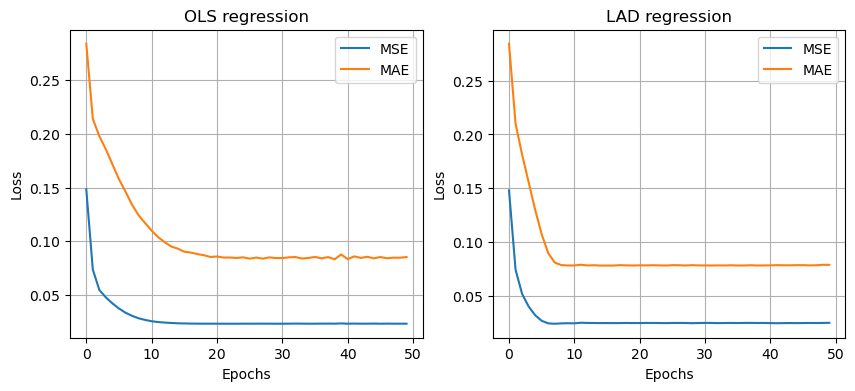

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(mse_history.history['mse'], label='MSE')
axes[0].plot(mse_history.history['mae'], label='MAE')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('OLS regression')
axes[0].legend(loc="upper right")
axes[0].grid(True)

axes[1].plot(mae_history.history['mse'], label='MSE')
axes[1].plot(mae_history.history['mae'], label='MAE')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('LAD regression')
axes[1].legend(loc="upper right")
axes[1].grid(True)

plt.show()

### Visualisation of OLS and LAD model fits

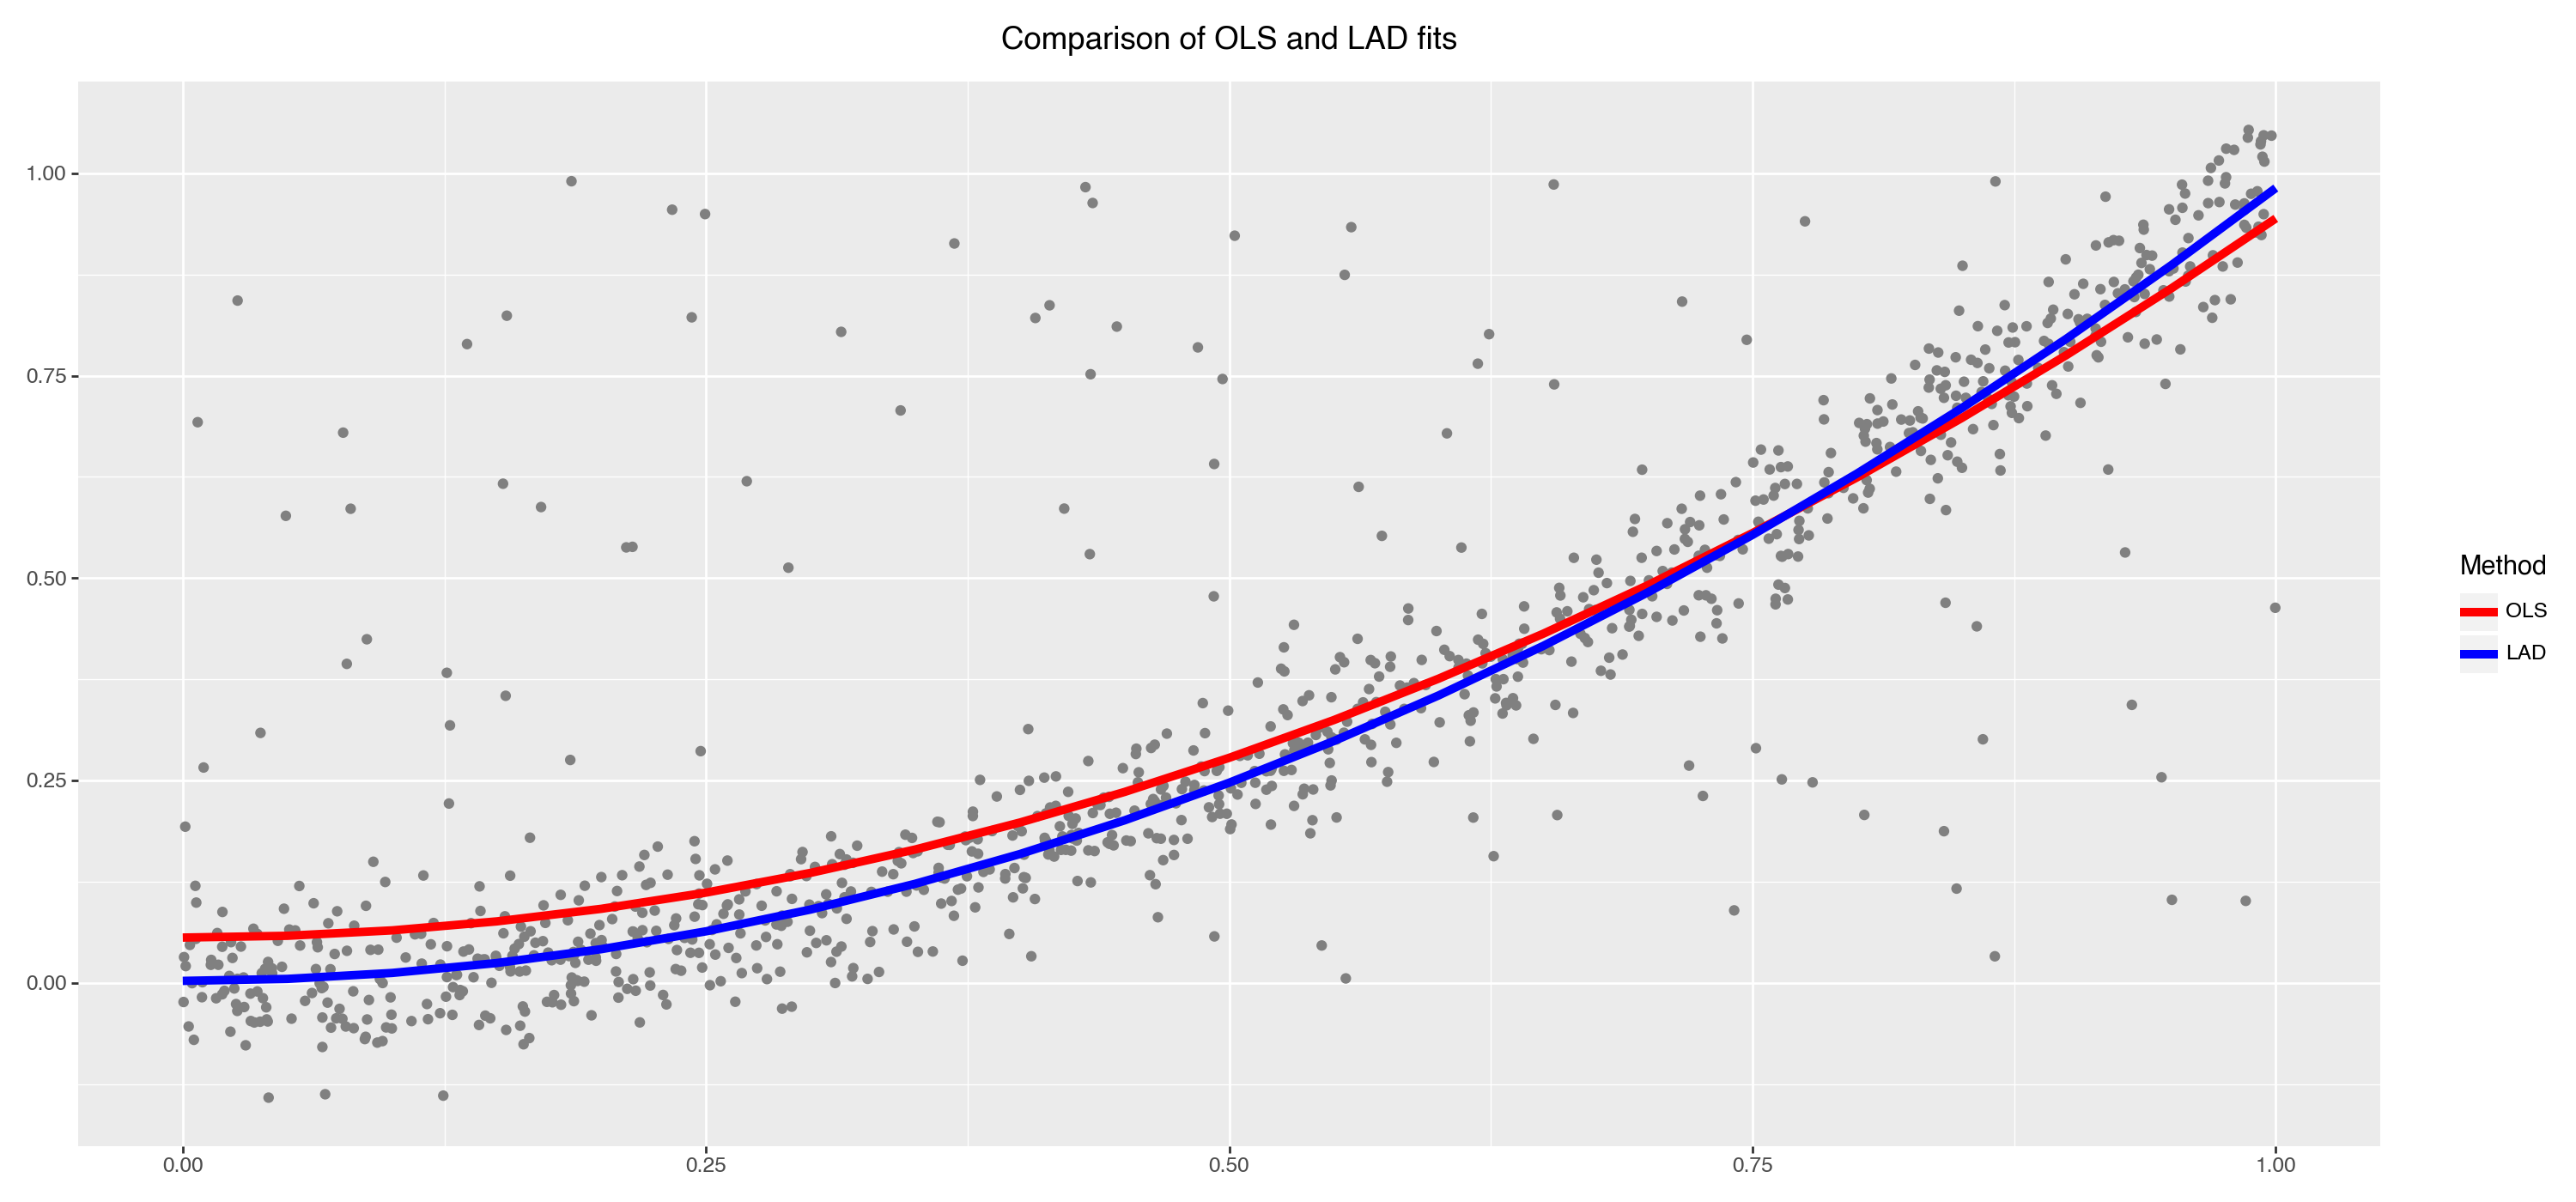

In [22]:
# Compute prediction line
dmse = DataFrame({'x':arange(0, 1.05, 0.05)})
dmse['y'] = mse_model.predict(dm['x'], verbose=0)

dmae = DataFrame({'x':arange(0, 1.05, 0.05)})
dmae['y'] = mae_model.predict(dm['x'], verbose=0)

# Show the corresponding graph 
p  = ggplot(df) 
p += geom_point(aes(x='$x^1$', y='$y$'), color='grey')
p += xlab('') 
p += ylab('') 
p += geom_line(aes(x='x', y='y', color='tmp'), data=dmse.assign(tmp=pd.Categorical(['OLS']*len(dmse), categories=['OLS', 'LAD'])), size=2)
p += geom_line(aes(x='x', y='y', color='tmp'), data=dmae.assign(tmp=pd.Categorical(['LAD']*len(dmse), categories=['OLS', 'LAD'])), size=2)
p += ggtitle('Comparison of OLS and LAD fits')
p += labs(x="", y='')
p += scale_color_manual(name = 'Method' ,breaks=['OLS', 'LAD'], values=['red', 'blue'])
display(p)

**Judgement:** The LAD fit follows the main mass of data significantly better than OLS fit.

### Visualisation of gradient search paths

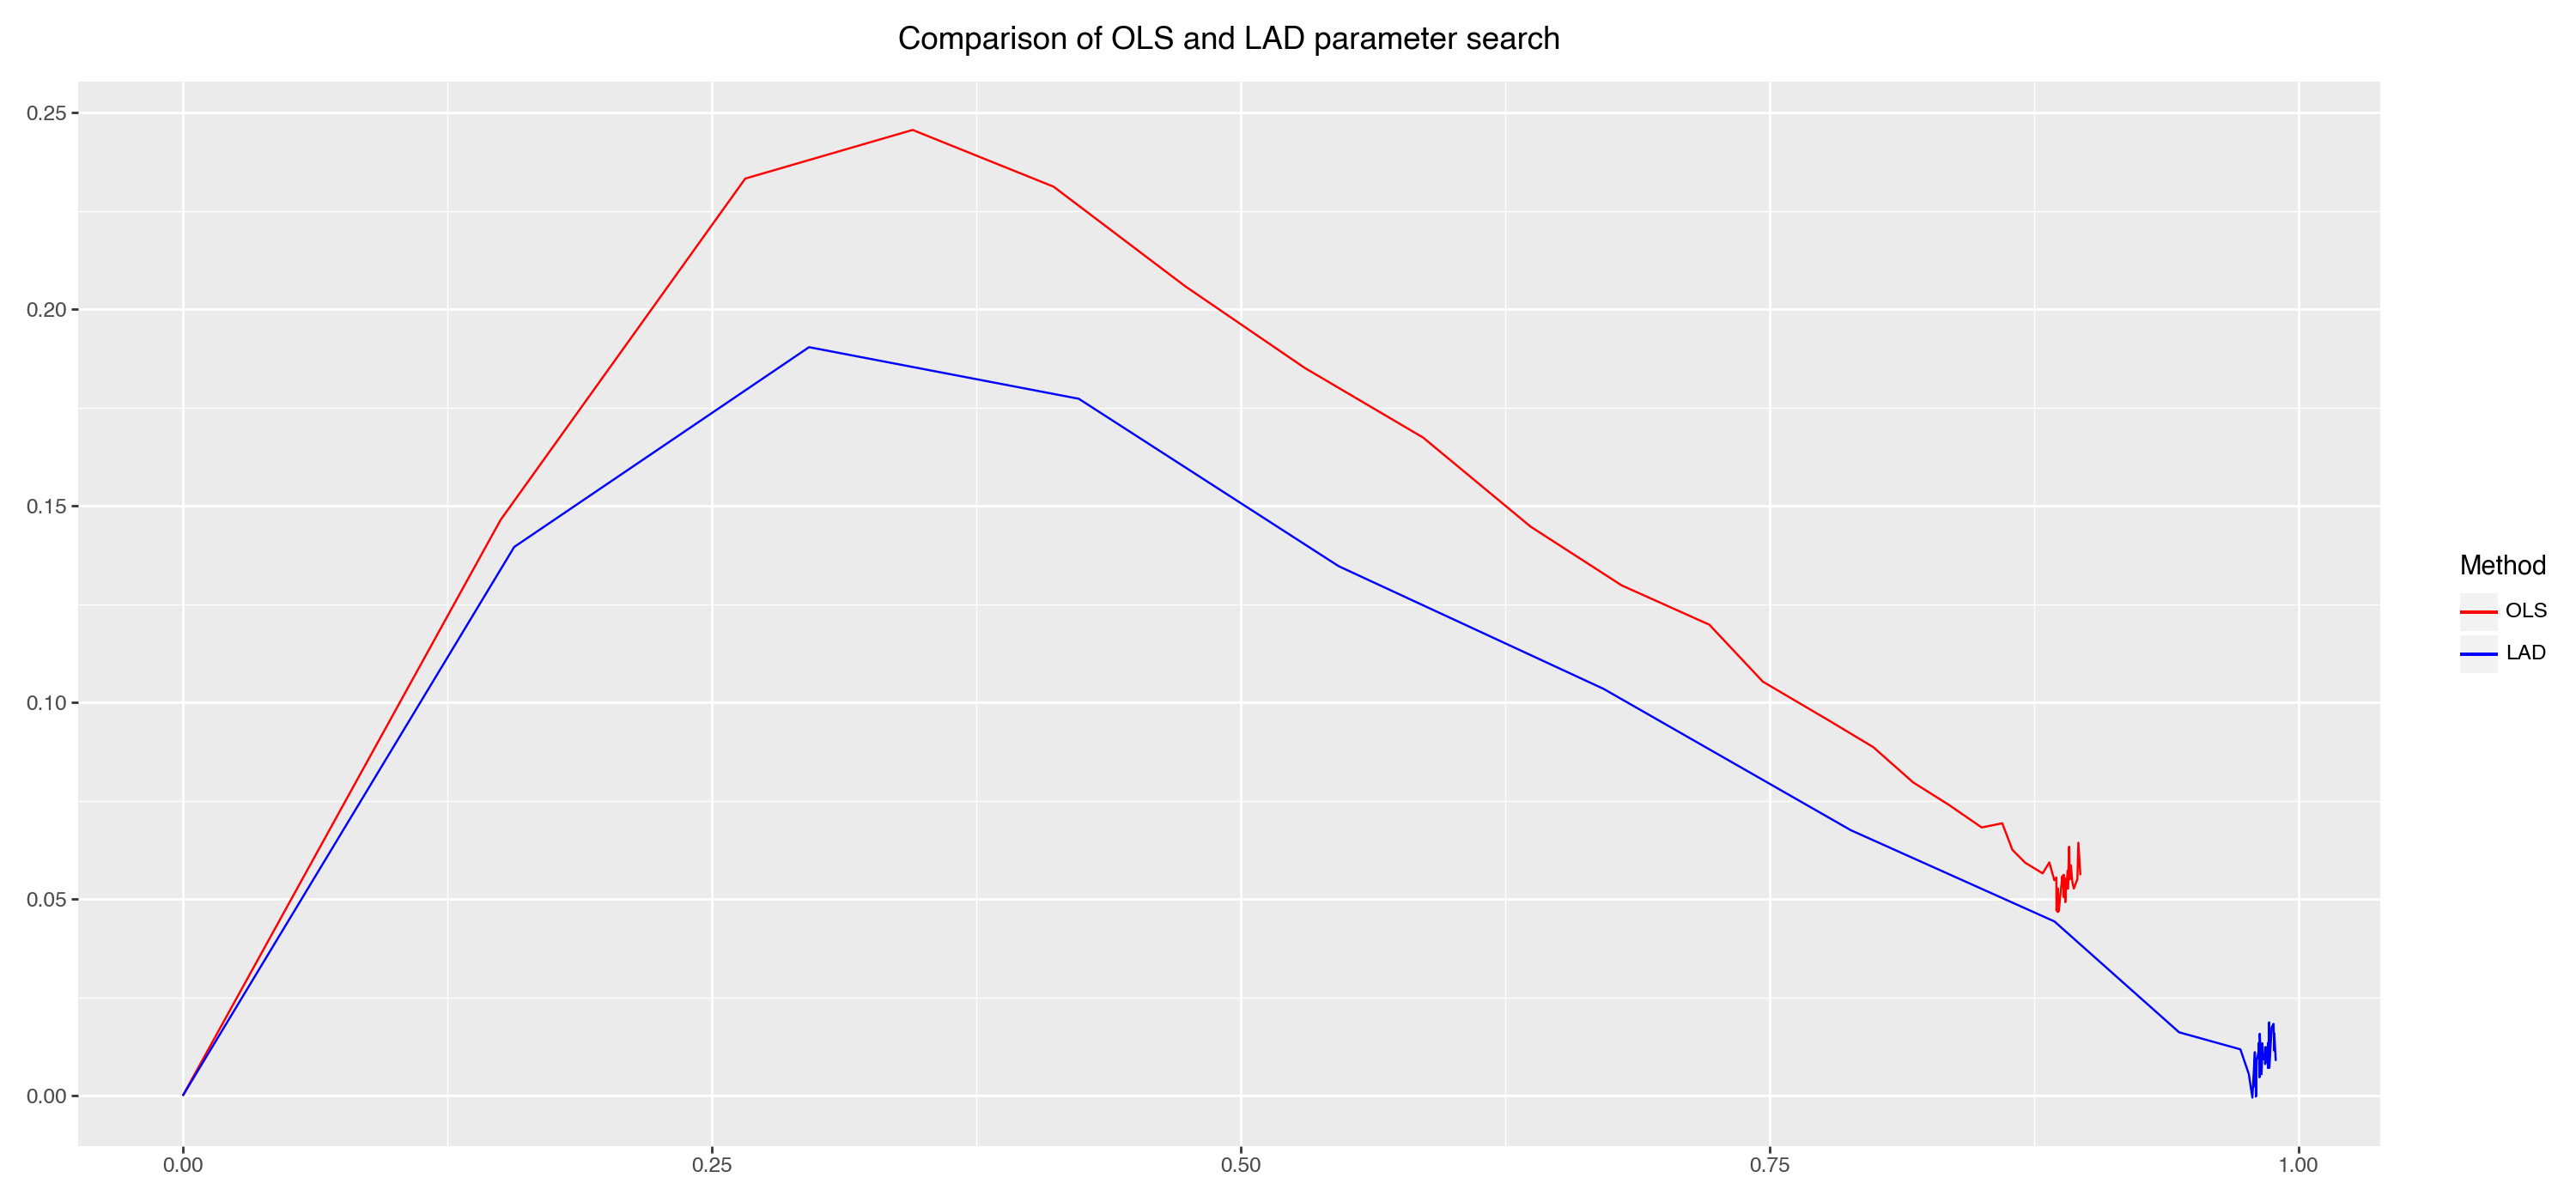

In [23]:
dpf = DataFrame({
    'epoch': range(epochs + 1),
    'mse_alpha': mse_tracker.weights_history,
    'mse_beta': mse_tracker.biases_history,
    'mae_alpha': mae_tracker.weights_history,
    'mae_beta': mae_tracker.biases_history,
    'mse': pd.Categorical(['OLS'] * (epochs + 1), categories=['OLS', 'LAD']), 
    'mae': pd.Categorical(['LAD'] * (epochs + 1), categories=['OLS', 'LAD']) 
})

p = ggplot(dpf) + xlab(r'$\alpha$') + ylab(r'$\beta$') 
p += geom_line(aes(x='mse_alpha', y='mse_beta', color='mse')) 
p += geom_line(aes(x='mae_alpha', y='mae_beta', color='mae')) 
p += ggtitle('Comparison of OLS and LAD parameter search')
p += labs(x="", y='')
p += scale_color_manual(name = 'Method' ,breaks=['OLS', 'LAD'], values=['red', 'blue'])
display(p)

**Judgement:** Both methods oscilate in final epochs -- learning rate is too big in these steps. 

### Visualisation of residual fits

In [24]:
ypred = mae_model.predict(df['$x^1$'], verbose=0).flatten()
residuals = DataFrame({'residuals': df['$y$'] - ypred, 'method': 'LAD'})
sigma_mae = residuals['residuals'].std()

ypred = mse_model.predict(df['$x^1$'], verbose=0).flatten()
residuals = pd.concat([residuals, DataFrame({'residuals': df['$y$'] - ypred, 'method': 'OLS'})], ignore_index=True)
sigma_mse = residuals['residuals'].std()

In [25]:
residuals

,residuals,method
0,-0.009038,LAD
1,0.006926,LAD
2,0.106201,LAD
3,0.091842,LAD
4,-0.230168,LAD
...,...,...
1995,-0.049974,OLS
1996,-0.063533,OLS
1997,-0.024579,OLS
1998,-0.024121,OLS


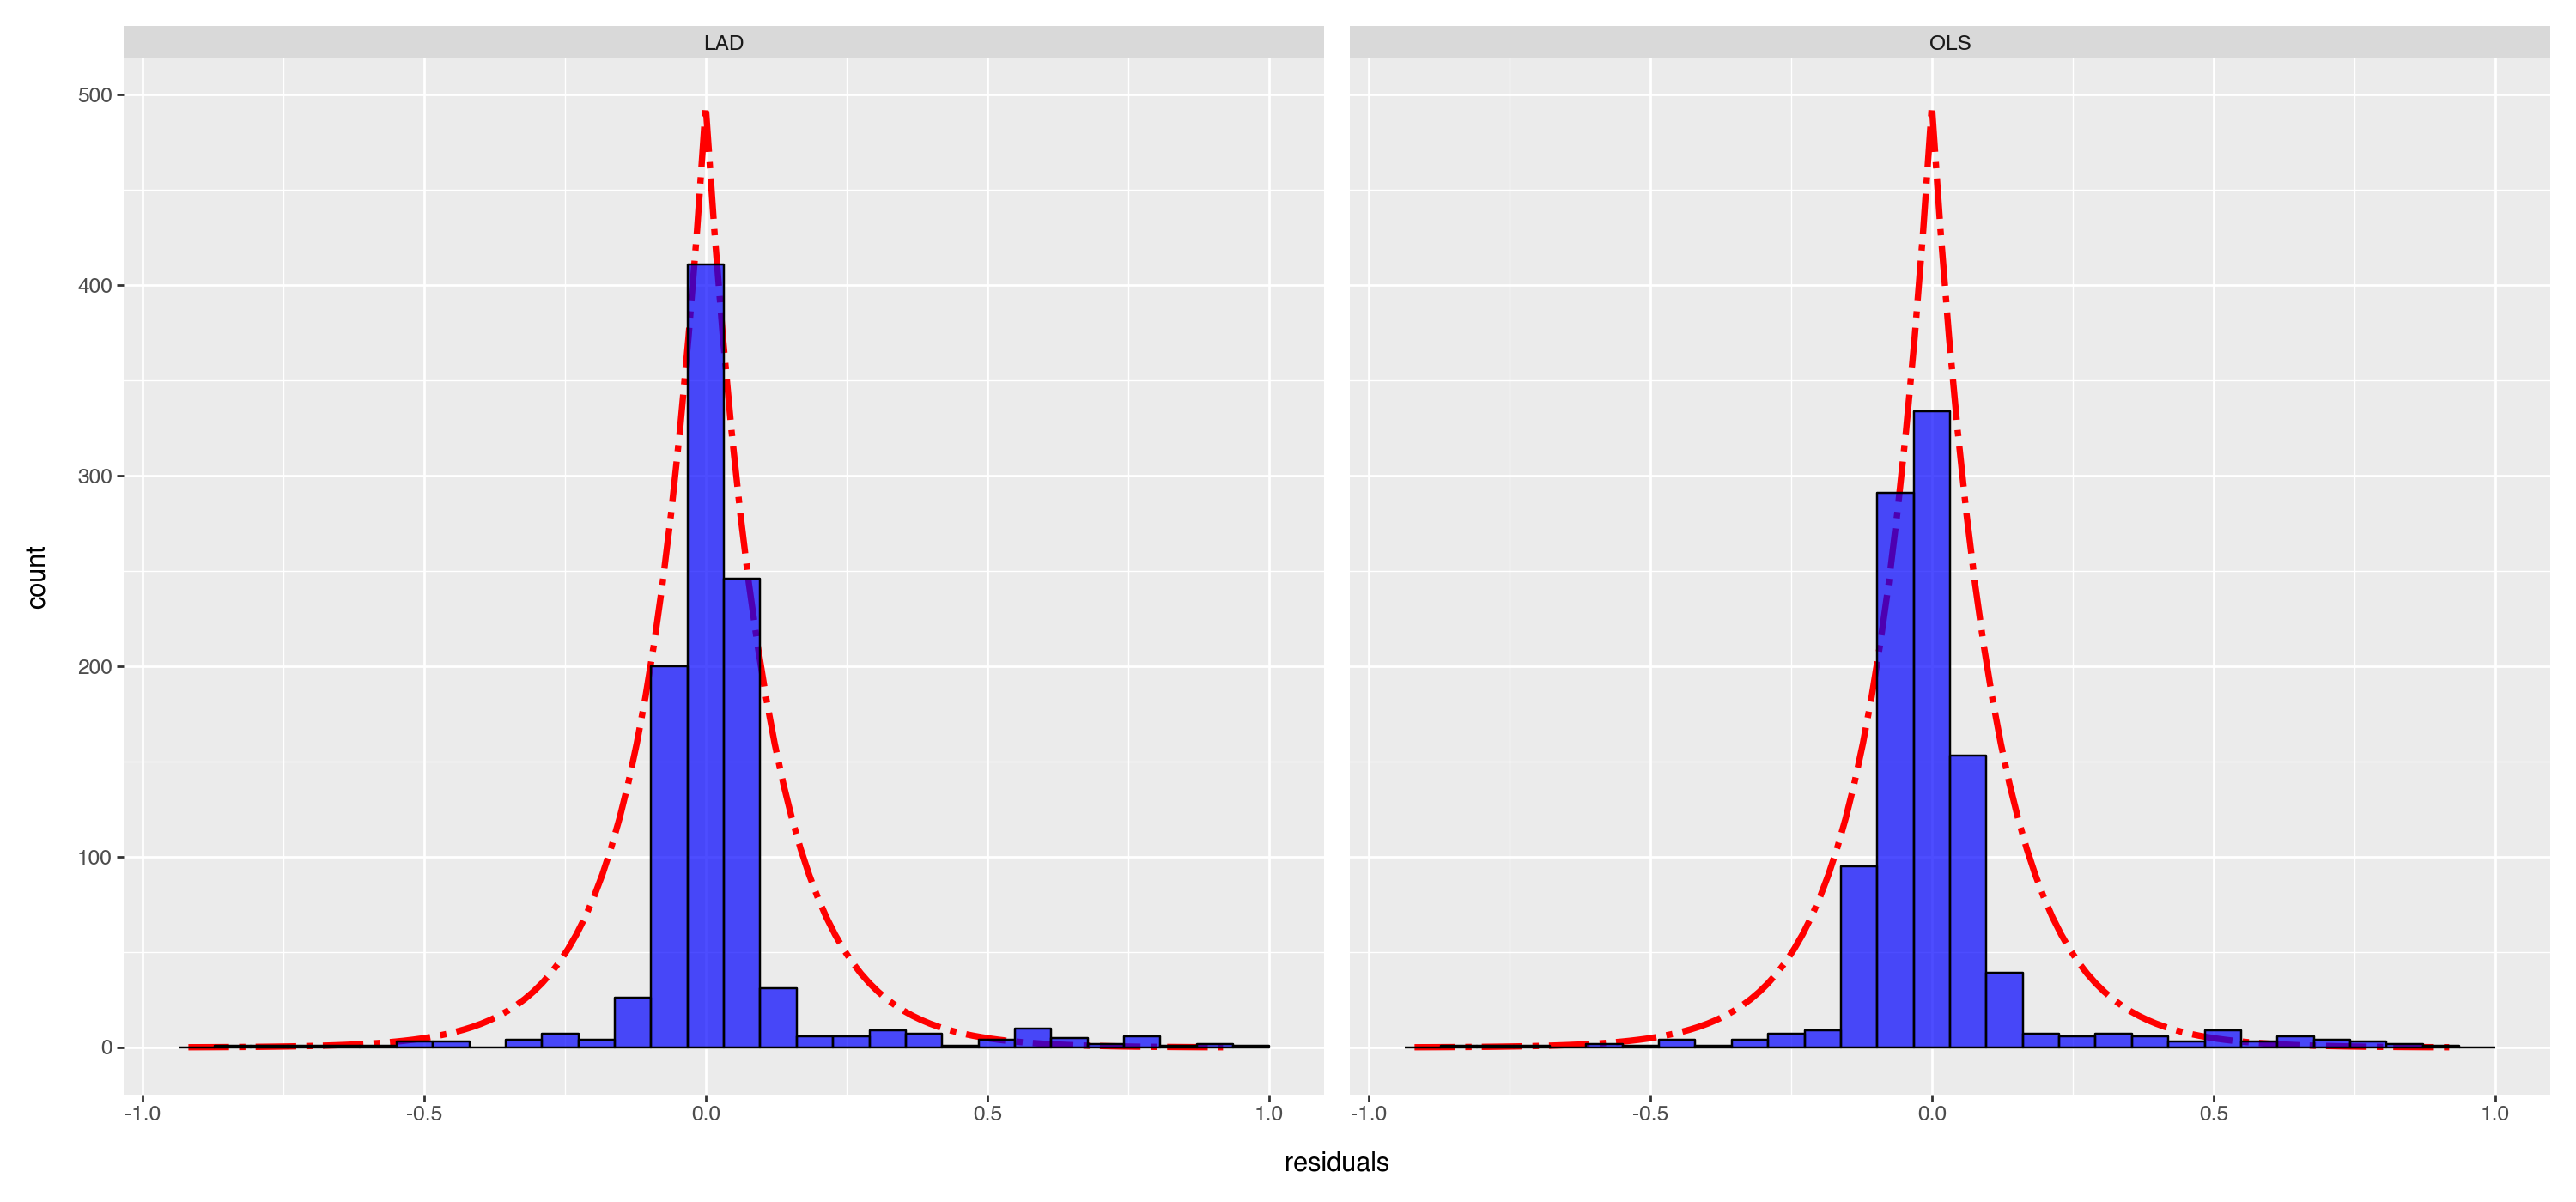

In [26]:
odf = DataFrame({'x': arange(-6*sigma, 6*sigma, sigma/10)})
# use moment matching to find good parameters for Laplace distribution
odf['p'] = norm.pdf(ndf['x'], loc=mu, scale=1/np.sqrt(2)*sigma_mse) 
odf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7 # Use tambov constant to align graphs
odf['method'] = 'OLS'

ldf = DataFrame({'x': arange(-6*sigma, 6*sigma, sigma/10)})
# use moment matching to find good parameters for Laplace distribution
ldf['p'] = laplace.pdf(ndf['x'], loc=mu, scale=1/np.sqrt(2)*sigma_mae) 
ldf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7 # Use tambov constant to align graphs
ldf['method'] = 'LAD'

p = ggplot(residuals) 
p += geom_line(aes(x='x', y='h'), data=odf, color='red', size=1.5, linetype='dashdot')
p += geom_line(aes(x='x', y='h'), data=ldf, color='red', size=1.5, linetype='dashdot')
p += geom_histogram(aes(x='residuals'), bins=30, fill="blue", color="black", alpha=0.7)
p += facet_wrap('method')
p += labs(x="residuals", y='count')
display(p)

**Judgement:** Residual matching is better for LAD model but residuals clearly do mot follow Laplace distribution. 

## IV. Ridge regression method 

One way to pose a priors to parameters of linear regression models $f_{\boldsymbol{w}}(\boldsymbol{x})=\boldsymbol{w}^T \boldsymbol{x}= x_1w_1+\ldots+x_mw_m$ is to assume that $|f_\boldsymbol{w}(\boldsymbol{x})|\leq c$ for all possible inputs form a certain region. Let us consider the unit ball with respect to Euclidean distance, i.e, we require 
\begin{align*}
||\boldsymbol{x}||^2=x_1^2+\cdots+x_m^2 \leq 1
\end{align*}

Note that the gradient  $\nabla f_{\boldsymbol{w}}=\boldsymbol{w}$ is constant over the entire search region and thus the solution must occur on the border.
Secondly note that from geometrical considerations the surface $g(\boldsymbol{x}) = x_1^2+\cdots+x_m^2 = 1$ is always ortogonal to the gradient $\nabla ||\boldsymbol{x}||^2=\boldsymbol{x}$. The corresponding analytical proof shows that if this is not the case then there must exist an inifidecimal step on the surface that increases $x_1^2+\cdots+x_m^2$ wich contradicts the costness of $g(\boldsymbol{x})$ on the surface. The same argument shows also that in the extremum point $\nabla f_{\boldsymbol{w}}$ must be colinear with  $\nabla g$ and thus the extramal values of $f_{\boldsymbol{w}}$ in two points 
\begin{align*}
\boldsymbol{x}=\pm\frac{\boldsymbol{w}}{||\boldsymbol{w}||}\enspace.
\end{align*}

Consequently, we get
\begin{align*}
-||\boldsymbol{w}||= -\frac{w_1w_1+\ldots+w_mw_m}{||\boldsymbol{w}||}\leq f_{\boldsymbol{w}}(\boldsymbol{x})\leq\frac{w_1w_1+\ldots+w_mw_m}{||\boldsymbol{w}||}=||\boldsymbol{w}||\enspace
\end{align*}

and thus we have a bound on the coefficients of linear regression model

\begin{align*}
||\boldsymbol{w}||^2 \leq c^2
\end{align*}

The latter leads to the posterior

\begin{align*}
p[\Theta|\boldsymbol{x}_,\ldots, \boldsymbol{x}_n,\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n]\propto
\prod_{i=1}^n p[\boldsymbol{y}_i|\boldsymbol{x}_i,\boldsymbol{w},\sigma]\cdot
\begin{cases}
1,&\text{if } ||\boldsymbol{w}||^2 \leq c^2\enspace,\\
0,&\text{if } ||\boldsymbol{w}||^2 > c^2\enspace.
\end{cases}
\end{align*}

As posterior is zero outside the region $||\boldsymbol{w}||^2 \leq c^2$ the posterior maximisation can be stated as a constrained optimisation task
\begin{align*}
&\ell[\boldsymbol{y}_,\ldots, \boldsymbol{y}_n|\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\Theta]
=\sum_{i=1}^n \ell[\boldsymbol{y}_i|\boldsymbol{x}_i,\boldsymbol{w},\sigma]\to \min\\
\end{align*}
such that $||\boldsymbol{w}||^2 \leq c^2$. Lagrange' trick allows us to recast this into unconstrained optimisation task
\begin{align*}
F=\frac{1}{n}\cdot\sum_{i=1}^n \ell[\boldsymbol{y}_i|\boldsymbol{x}_i,\boldsymbol{w},\sigma]+\lambda ||\boldsymbol{w}||^2\to \min\\
\end{align*}
where $\lambda \geq 0$ is unknown constant that depends on $c$. 
Normally, we have no clue what is the right value of $c$ and thus we just need to guess the value of $\lambda$ that provides us the best outcome -- whatever the best means in our context. 

For linear models with additive Gaussian noise, the resulting closed form solution 
\begin{align*}
\boldsymbol{w} = (X^T X+\lambda I)^{-1} X^T\boldsymbol{y} 
\end{align*}

differs from the standard solution 

\begin{align*}
\boldsymbol{w} = (X^T X)^{-1} X^T\boldsymbol{y} 
\end{align*}

only by the diagonal "ridge" that is added to the matrix $X^T X$ before inverting it. Such a regularisation technique is well known numerical method that reduces the impact of errors to the outcome. In this context, the errors are additive fluctuations $\varepsilon_i$ and thus each observation $(\boldsymbol{x}_i, y_i)$ has a limited impact on coefficents $\boldsymbol{w}$.    




## V. LASSO regression method 

We can also assume that $|f_\boldsymbol{w}(\boldsymbol{x})|\leq c$  the unit ball with respect maximum norm, i.e, we require 
\begin{align*}
||\boldsymbol{x}||_\infty=\max(|x_1|,\ldots,|x_m|) \leq 1
\end{align*}
It is straightforward to see that $f_{\boldsymbol{w}}(\boldsymbol{x})= x_1w_1+\ldots+x_mw_m$ has extremal points only if $x_i\in\{-1,1\}$ and thus
\begin{align*}
-|w_1|-\ldots-|w_m|\leq f_\boldsymbol{w}(\boldsymbol{x}) \leq |w_1|+\ldots+|w_m|
\end{align*}
and our original constraint translates to a requirement
\begin{align*}
||\boldsymbol{w}||_1= |w_1|+\ldots+|w_m|\leq c.
\end{align*}
Again we can ignore posterior region with zero probability and seek Maximum Aposteriori solution through constrained optimisation task
\begin{align*}
&\ell[\boldsymbol{y}_,\ldots, \boldsymbol{y}_n|\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n,\Theta]
=\sum_{i=1}^n \ell[\boldsymbol{y}_i|\boldsymbol{x}_i,\boldsymbol{w},\sigma]\to \min\\
\end{align*}
such that $||\boldsymbol{w}||_1 \leq c$. Lagrange' trick allows us to recast this into unconstrained optimisation task
\begin{align*}
F=\frac{1}{n}\cdot\sum_{i=1}^n \ell[\boldsymbol{y}_i|\boldsymbol{x}_i,\boldsymbol{w},\sigma]+\lambda ||\boldsymbol{w}||_1\to \min\\
\end{align*}
where $\lambda \geq 0$ is unknown constant that depends on $c$. 
Normally, we have no clue what is the right value of $c$ and thus we just need to guess the value of $\lambda$ that provides us the best outcome -- whatever the best means in our context. 

The geometrical properties of ordinary linear regression task assure that resulting solution is sparse. Thus the method is known as LASSO. 

# Homeworks

## 7.1 Histogram matching$^*$ (<font color='red'>1p</font>)

In the graphs above use used hand-tuned scaling factor to align density function with histograms. This is not a good practise. Derive a formula for scaling the density function given that all bins in the histogram have equal lengths. For that compute what is the expected number of observations for each bin and choose the scaling factor so that area under each bin is equal to the expected number of observations. Implement the corresponding algorithm and redraw LAD vs OLS histograms.  Test correctness of your scaling using simulation to be sure.

## 7.2 Normalised error metrics (<font color='red'>1p</font>)

Note that MSE and MAE quality metric are not scale invariant. By increasing the outcome 10 times we also increase minimal MSE 100 times and MAE 10 times. This is not a problem if you want to compare different methods on the same dataset, but sometimes you really need to compare model performances over different datasets. Then it is common to use normalised error metrics that are defined
\begin{align*}
\text{NScore}=\frac{\text{Model score}}{\text{Best base model score}}\enspace.
\end{align*}

For linear models, the set of base models are constant predictors $y = y_0$. Compute normalised MSE and MAE scores for [the regression bencmark](data/regression_benchmark.csv) use in this notebook. **Bonus:** Explain how $R^2$-score is connected with normalised scores (<font color='red'>1p</font>).


## 7.3 Comparison of Ridge and LASSO regression algorithms (<font color='red'>3p+1p</font>)


This exercise shows basic similarities and differences between regularised linear regression methods. For all experiments, generate a data set consisting of $20$ inputs $x_1,\ldots,x_{20}$ sampled uniformly and independently form the range  $[0,1]$ and set $y=x_1+\varepsilon$ where $\varepsilon$ comes from normal distribution $\mathcal{N}(0,\sigma)$. 

* Do experiments with 100 element dataset. Fix inputs $\boldsymbol{x}_1,\ldots, \boldsymbol{x}_{100}$ first and then sample different responses to the same input data and compare predicted coefficients for different levels of noise $\sigma\in\set{0,0.1, 1, 10}$. Use ordinary least squares regression to find coeffients. Make at least $10$ experiments for each noise level and draw the values of coefficients as dots on a scatter plot where coefficients labels are on $x$-axis.  Interpret results. (<font color='red'>1p</font>)

* Repeat the same experiment with ridge regression. Fix a noise level $\sigma$ for which the ordinary least squares regression does not provide the correct answer and study how the coefficients of ridge regression depend on $\lambda \in [0, \infty]$. Obviousy, you cannot choose $\lambda=\infty$. Instead, use some large value like $\lambda=10^6$ that has the same effect. Draw corresponding graph where $x$-axis depicts $\lambda$-values and $y$-axis depicts coefficient values. Make at least $10$ experiments when you draw the graph. Interpret results.    (<font color='red'>1p</font>)   

* Repeat the same experiment with LASSO regression. Fix a noise level $\sigma$ for which the ordinary least squares regression does not provide the correct answer and study how the coefficients of LASSO regression depend on $\lambda \in [0, \infty]$. Obviousy, you cannot choose $\lambda=\infty$. Instead, use some large value like $\lambda=10^6$ that has the same effect. Draw corresponding graph where $x$-axis depicts $\lambda$-values and $y$-axis depicts coefficient values. Make at least $10$ experiments when you draw the graph. Interpret results.    (<font color='red'>1p</font>) 

* The first three experiments show how the noise impacts the inferred coefficient values. This is somewhat irrelevant if you are interested in predictions only. Redo the experiments so that you can visualise prediction graph for inputs $x_1\in[0,1]$ and $x_2=0,\ldots, x_{20}=0$. Intewrpret result: do they confirm the theory behind regularisation.  (<font color='red'>1p</font>) 


In [108]:
from numpy import linspace
from numpy.random import uniform
from numpy.random import normal

In [80]:
ols = LinearRegression(fit_intercept=False)

X = DataFrame(uniform(low=0, high=1, size=2000).reshape(100, 20), columns=[f'x_{i+1}' for i in range(20)])
y = X['x_1'] + normal(loc=0, scale=1, size=100)
ols = ols.fit(X, y) 

In [81]:
fits = DataFrame({'exp': 1, 'i': range(1, 21),  'beta': ols.coef_})

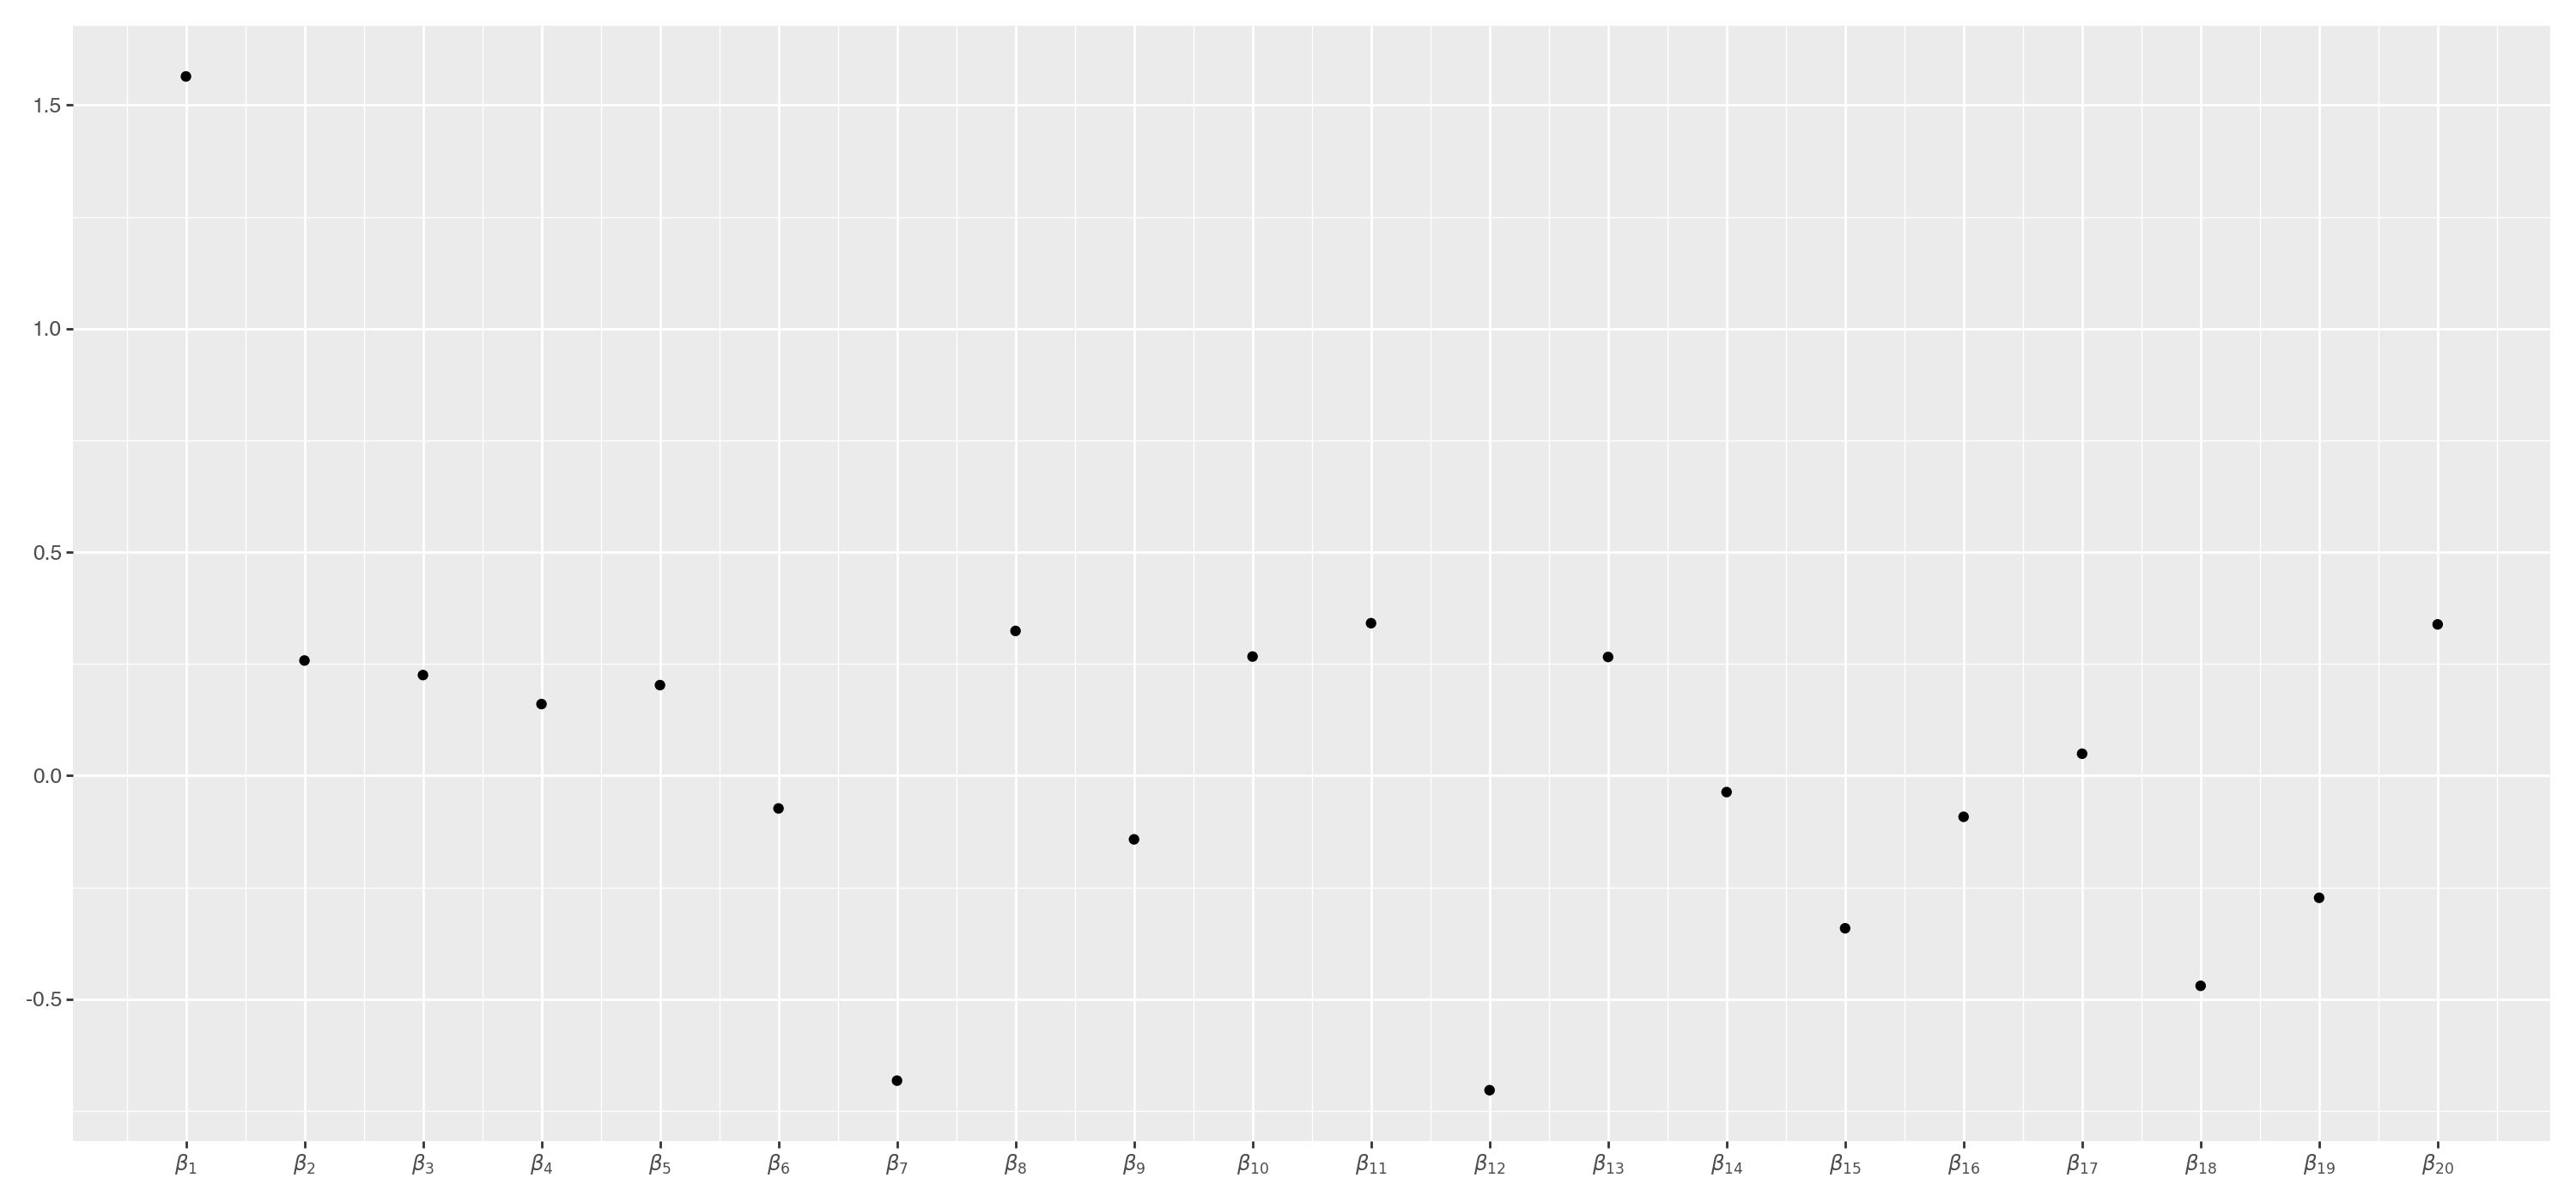

In [82]:
p = ggplot(fits) + geom_point(aes(x='i', y='beta')) 
p += scale_x_continuous(name='',breaks=list(range(1, 21)), labels=[rf'$\beta_{{{i+1}}}$' for i in range(20)])
p += ylab('')
p

In [120]:
Xt = DataFrame(np.zeros((50, 20)), columns=[f'x_{i+1}' for i in range(20)])
Xt['x_1'] = linspace(0, 1, 50)
pred = DataFrame({'x': Xt['x_1'], 'y': ols.predict(Xt)})

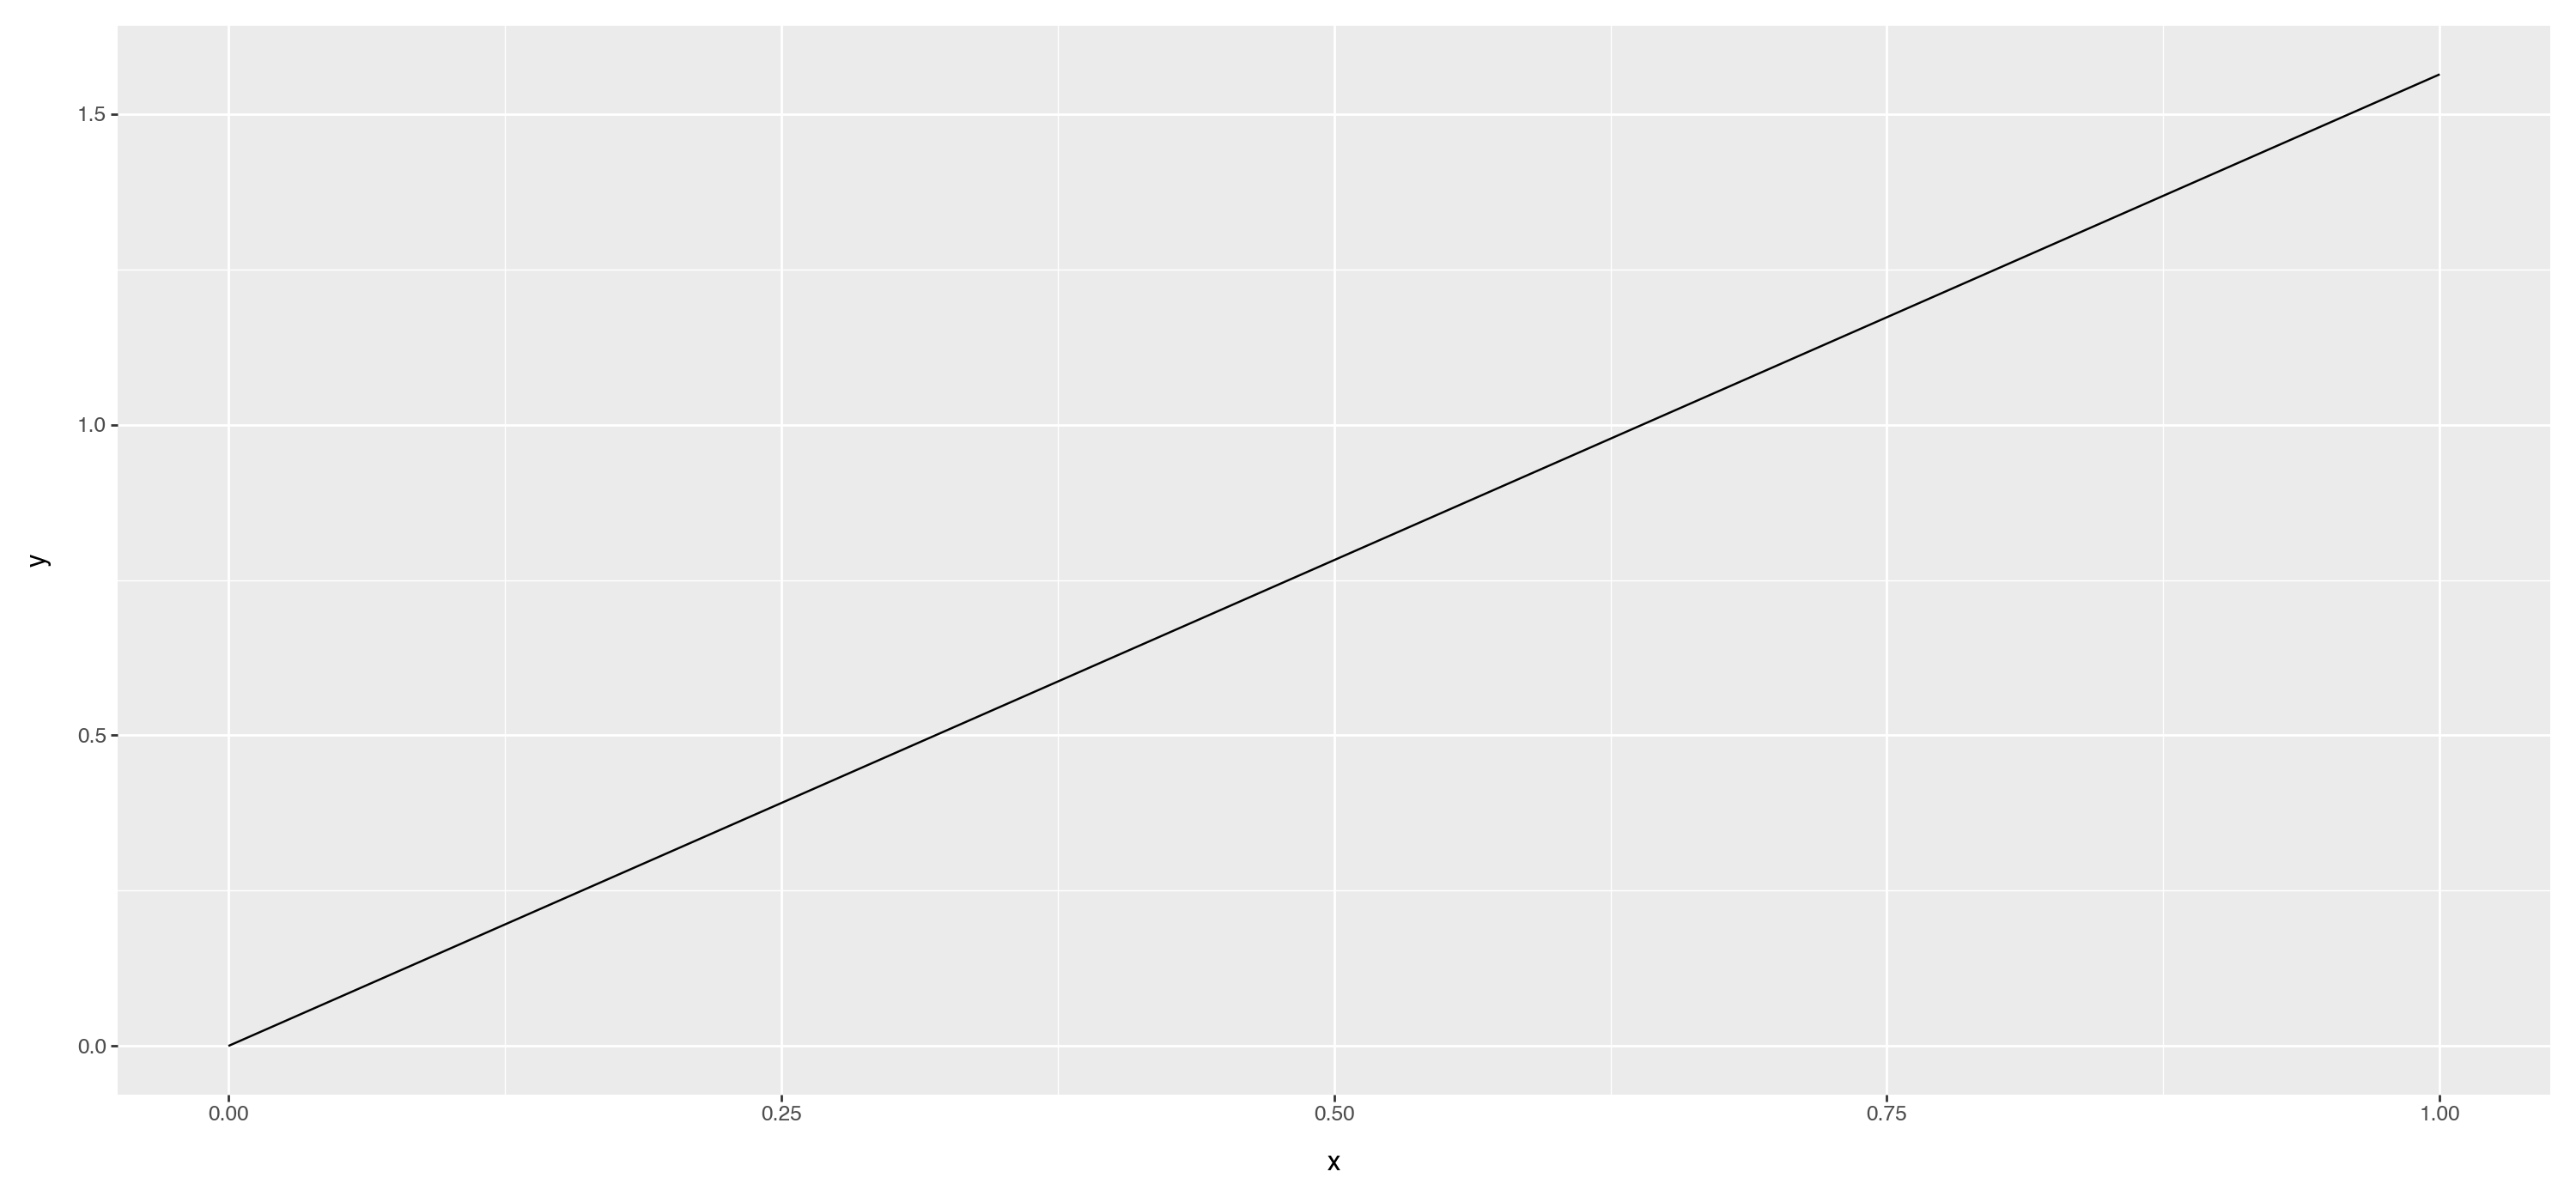

In [121]:
p = ggplot(pred) + geom_line((aes(x='x', y='y')))
p

In [83]:
from sklearn.linear_model import Ridge

In [95]:
ridge = Ridge(alpha=100, fit_intercept=False)
ridge = ridge.fit(X, y)

In [96]:
fits = DataFrame({'exp': 1, 'i': range(1, 21),  'beta': ridge.coef_})

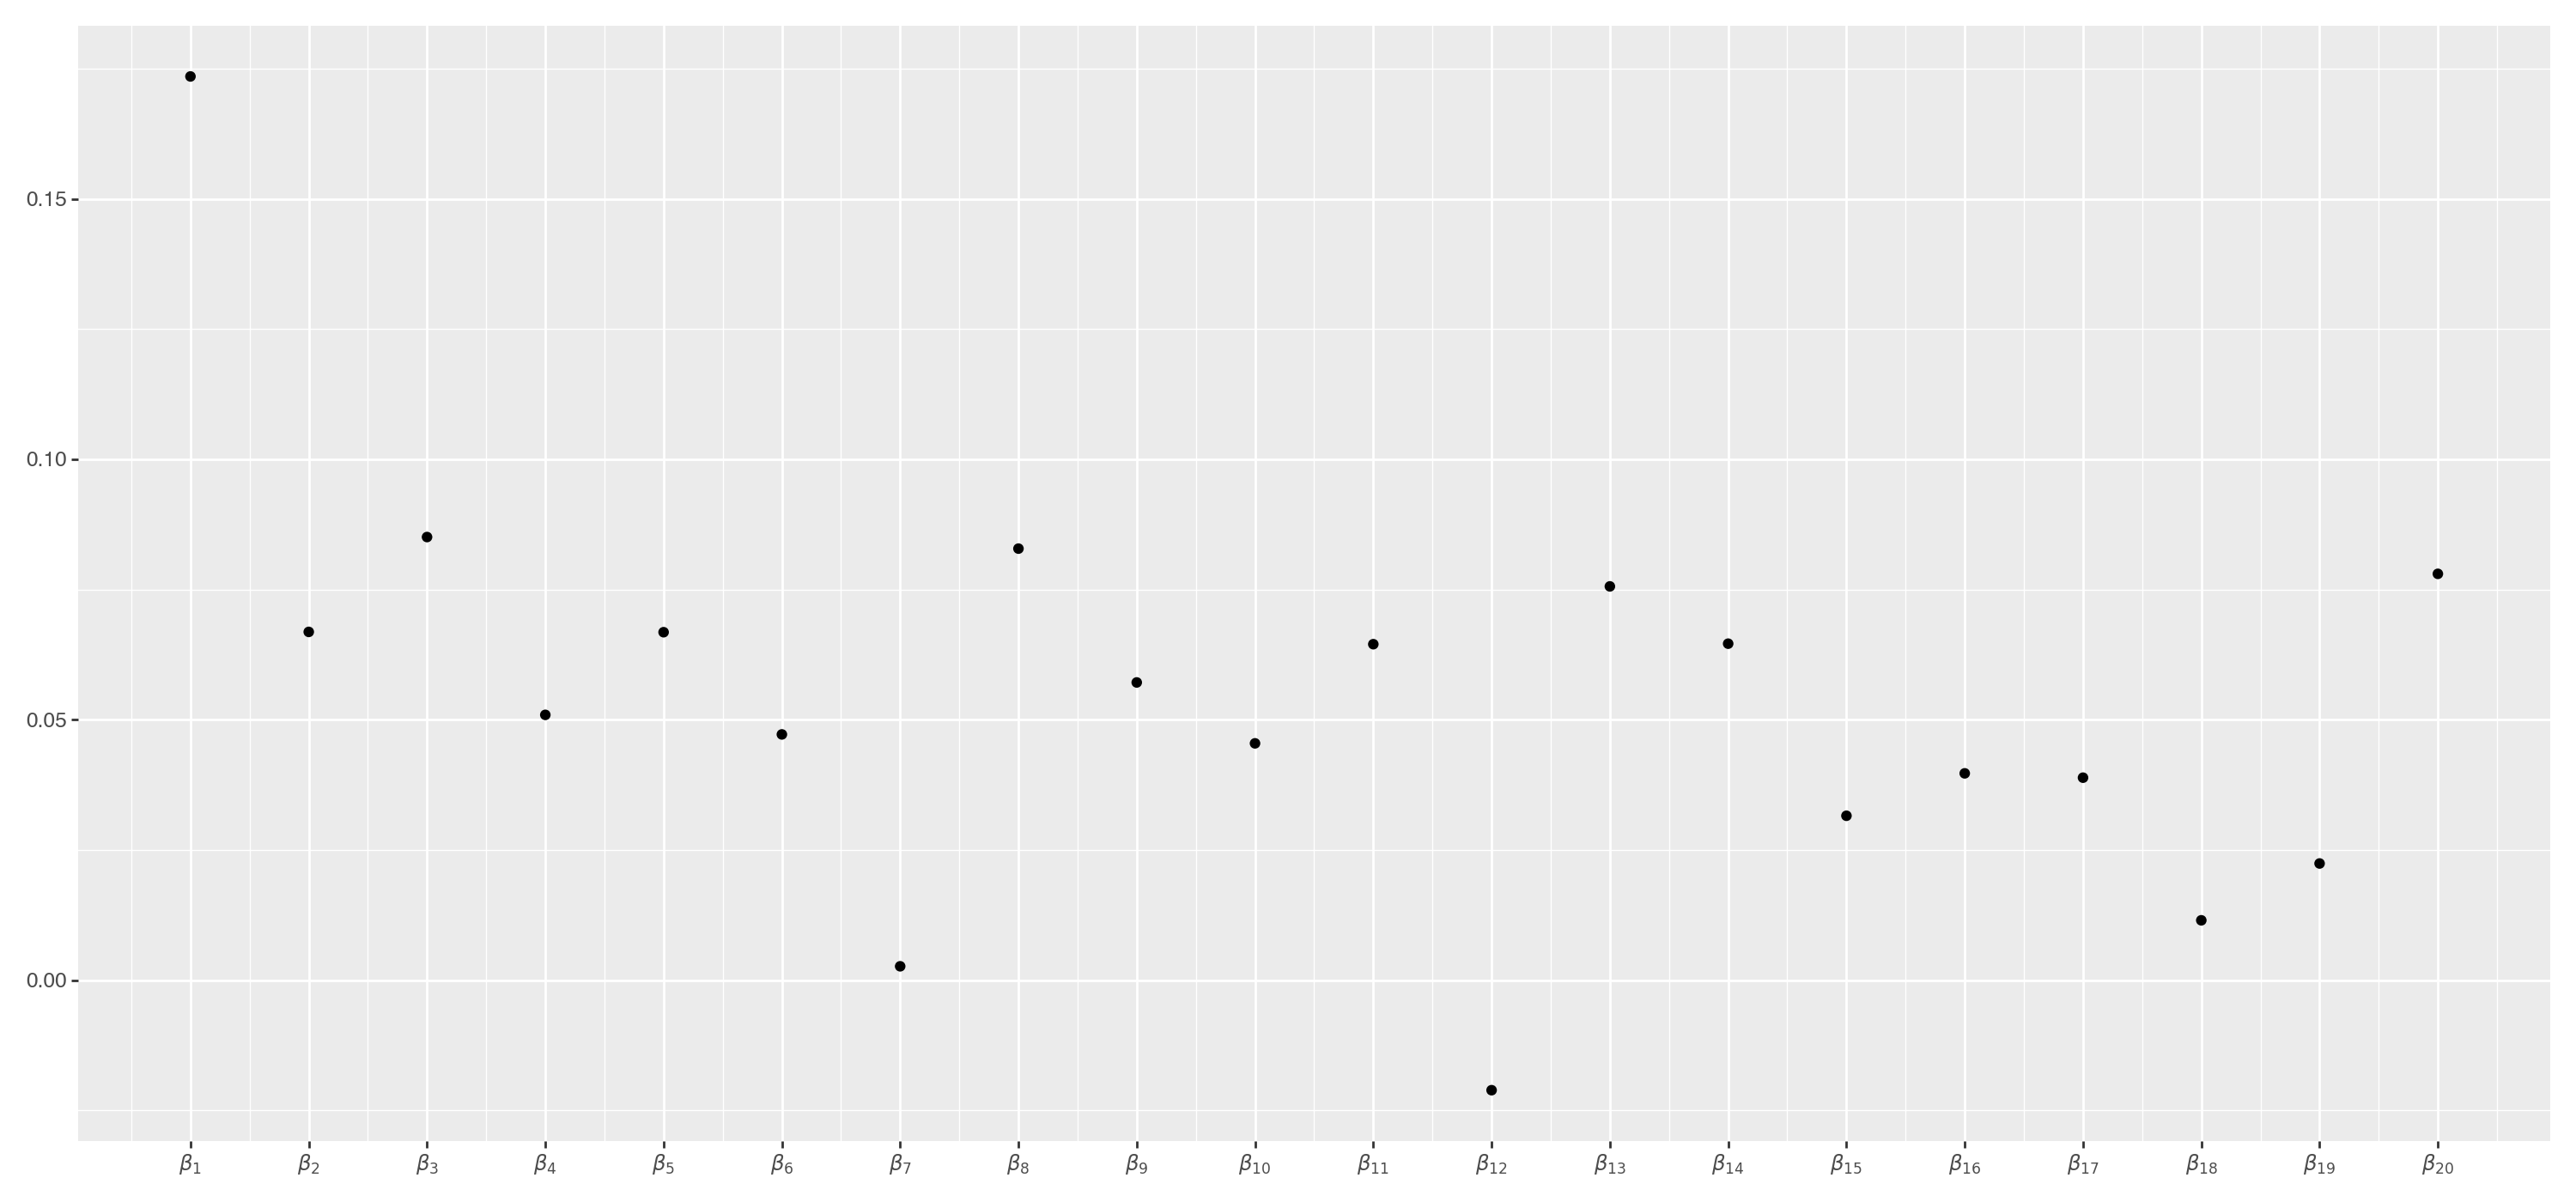

In [98]:
p = ggplot(fits) + geom_point(aes(x='i', y='beta')) 
p += scale_x_continuous(name='',breaks=list(range(1, 21)), labels=[rf'$\beta_{{{i+1}}}$' for i in range(20)])
p += ylab('')
p

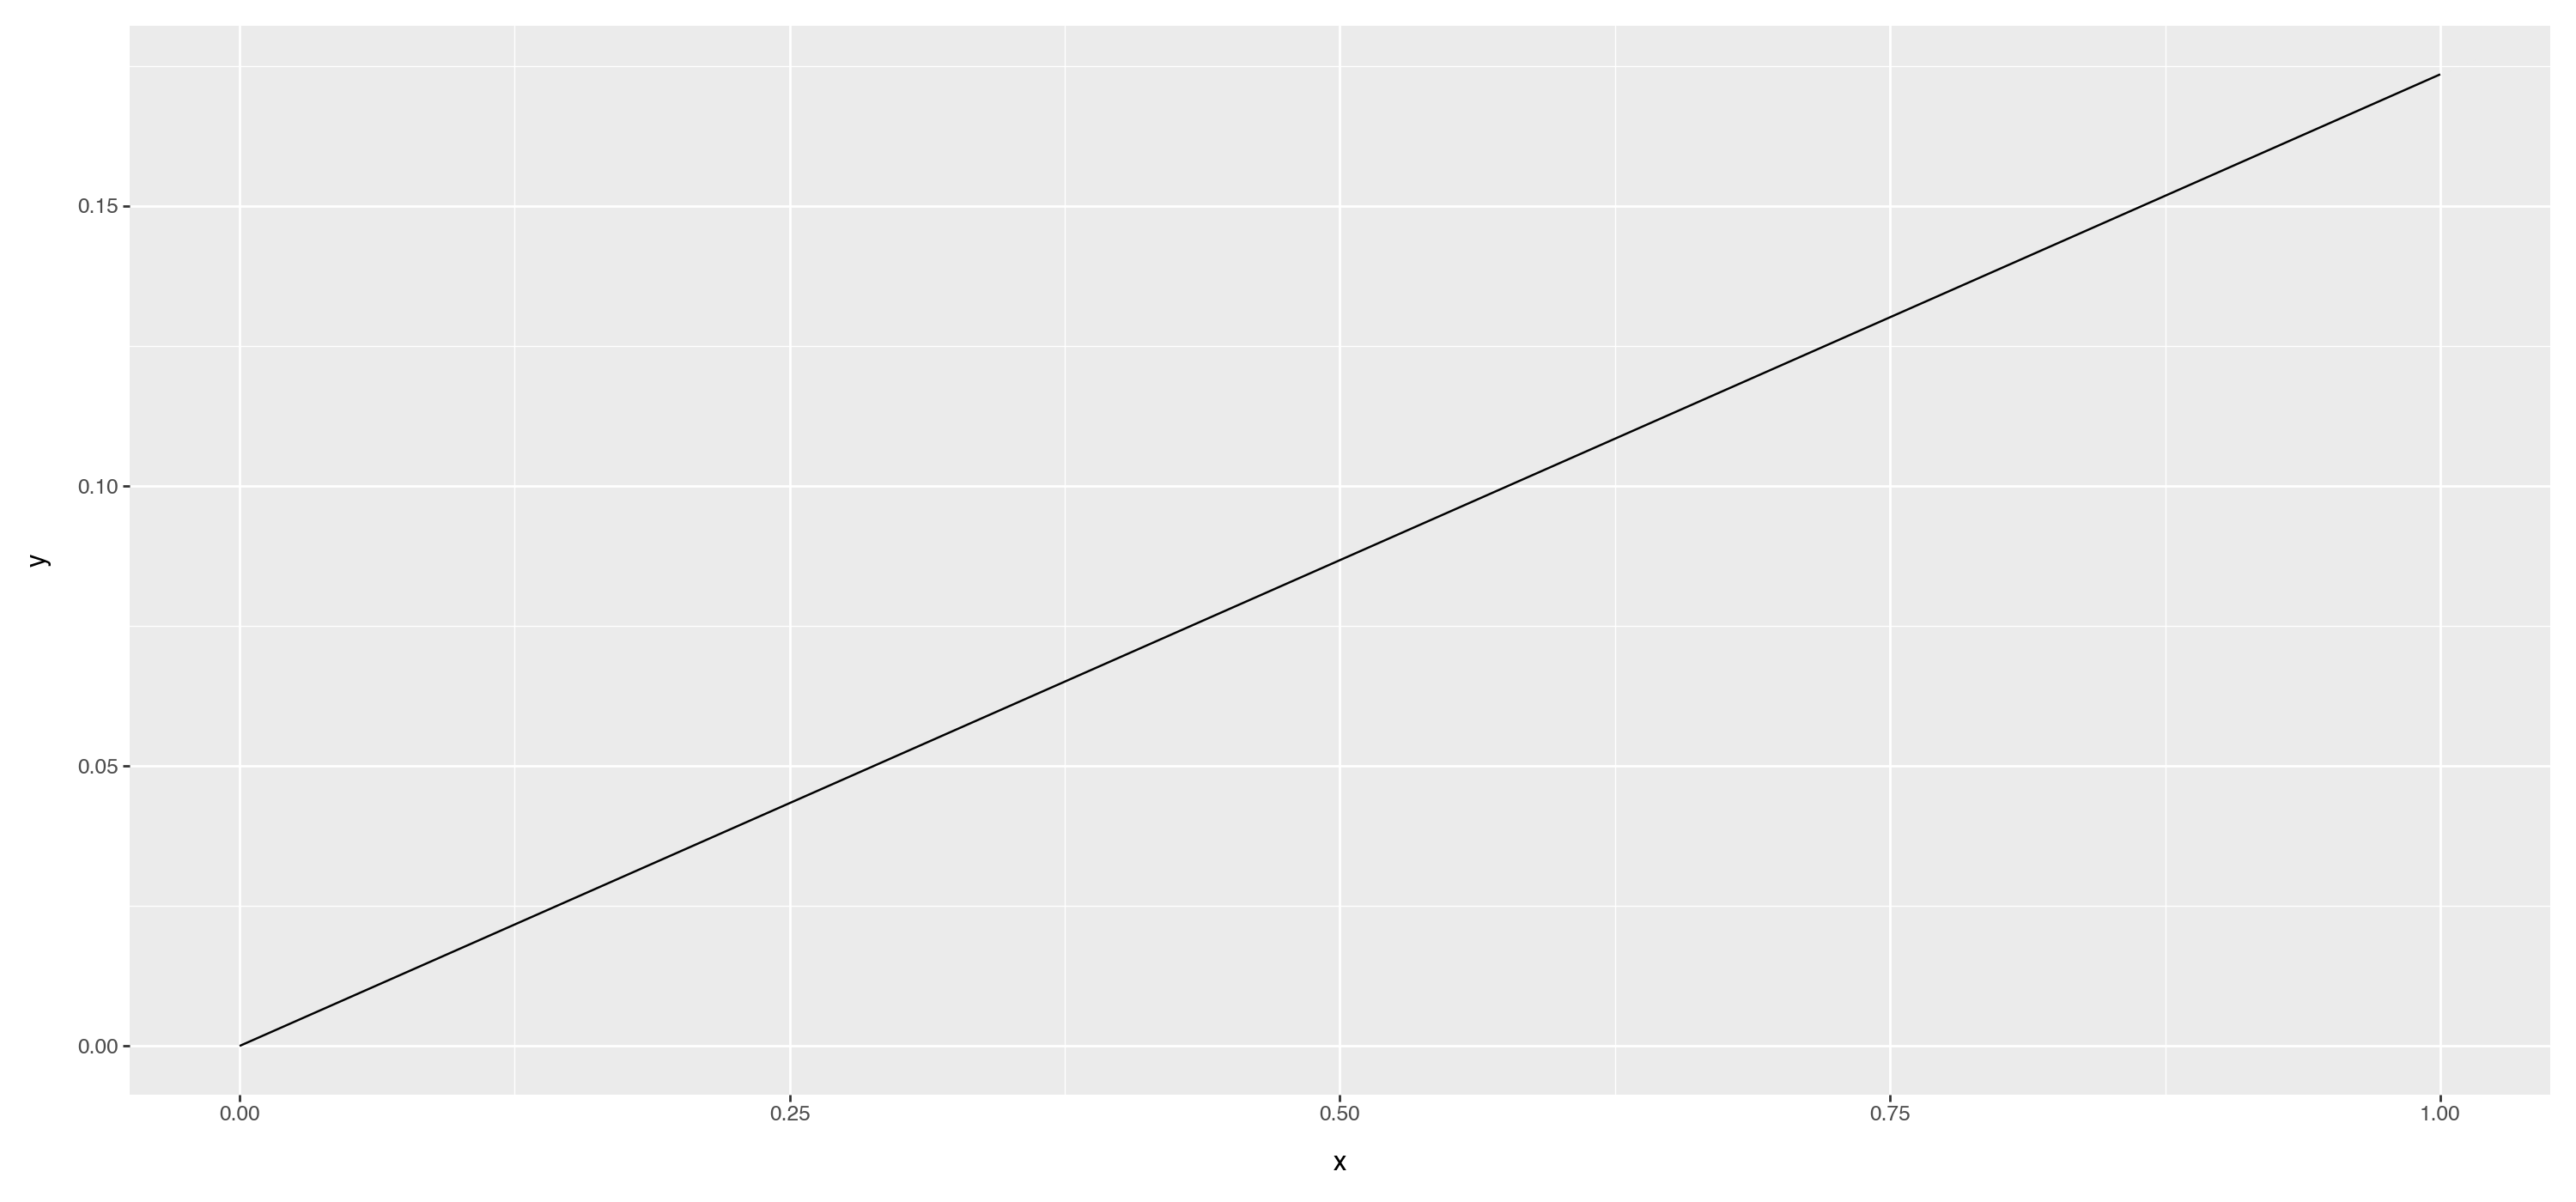

In [123]:
pred = DataFrame({'x': Xt['x_1'], 'y': ridge.predict(Xt)})
p = ggplot(pred) + geom_line((aes(x='x', y='y')))
p

In [124]:
from sklearn.linear_model import Lasso

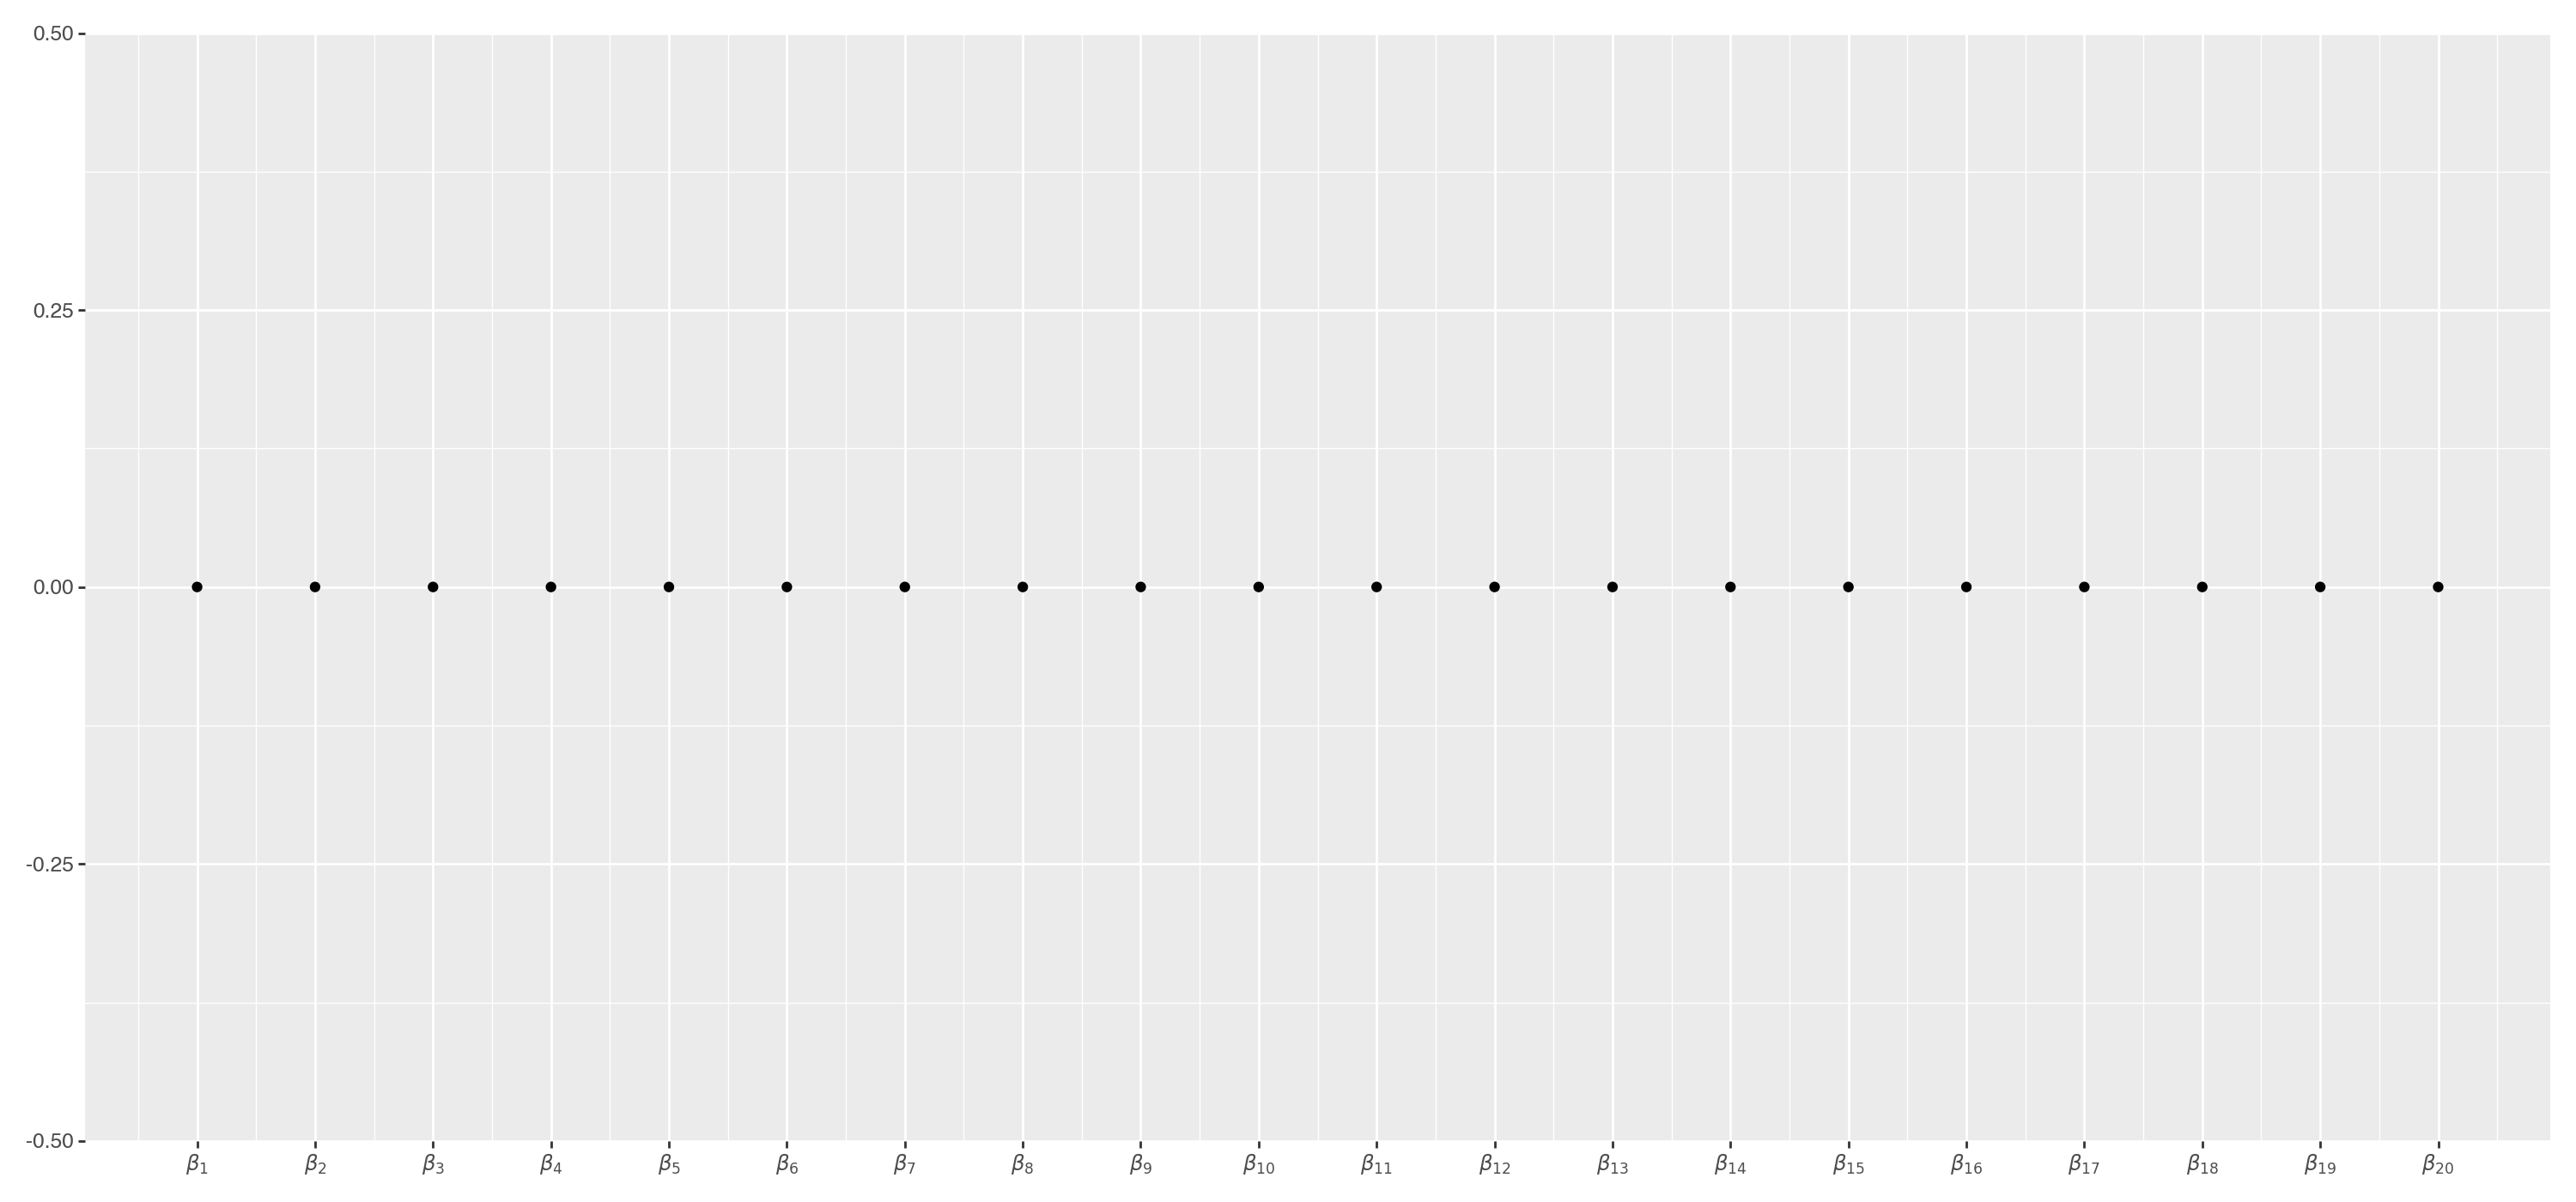

In [142]:
lasso = Lasso(alpha=1, fit_intercept=False)
lasso = lasso.fit(X, y)
fits = DataFrame({'exp': 1, 'i': range(1, 21),  'beta': lasso.coef_})

p = ggplot(fits) + geom_point(aes(x='i', y='beta')) 
p += scale_x_continuous(name='',breaks=list(range(1, 21)), labels=[rf'$\beta_{{{i+1}}}$' for i in range(20)])
p += ylab('')
p

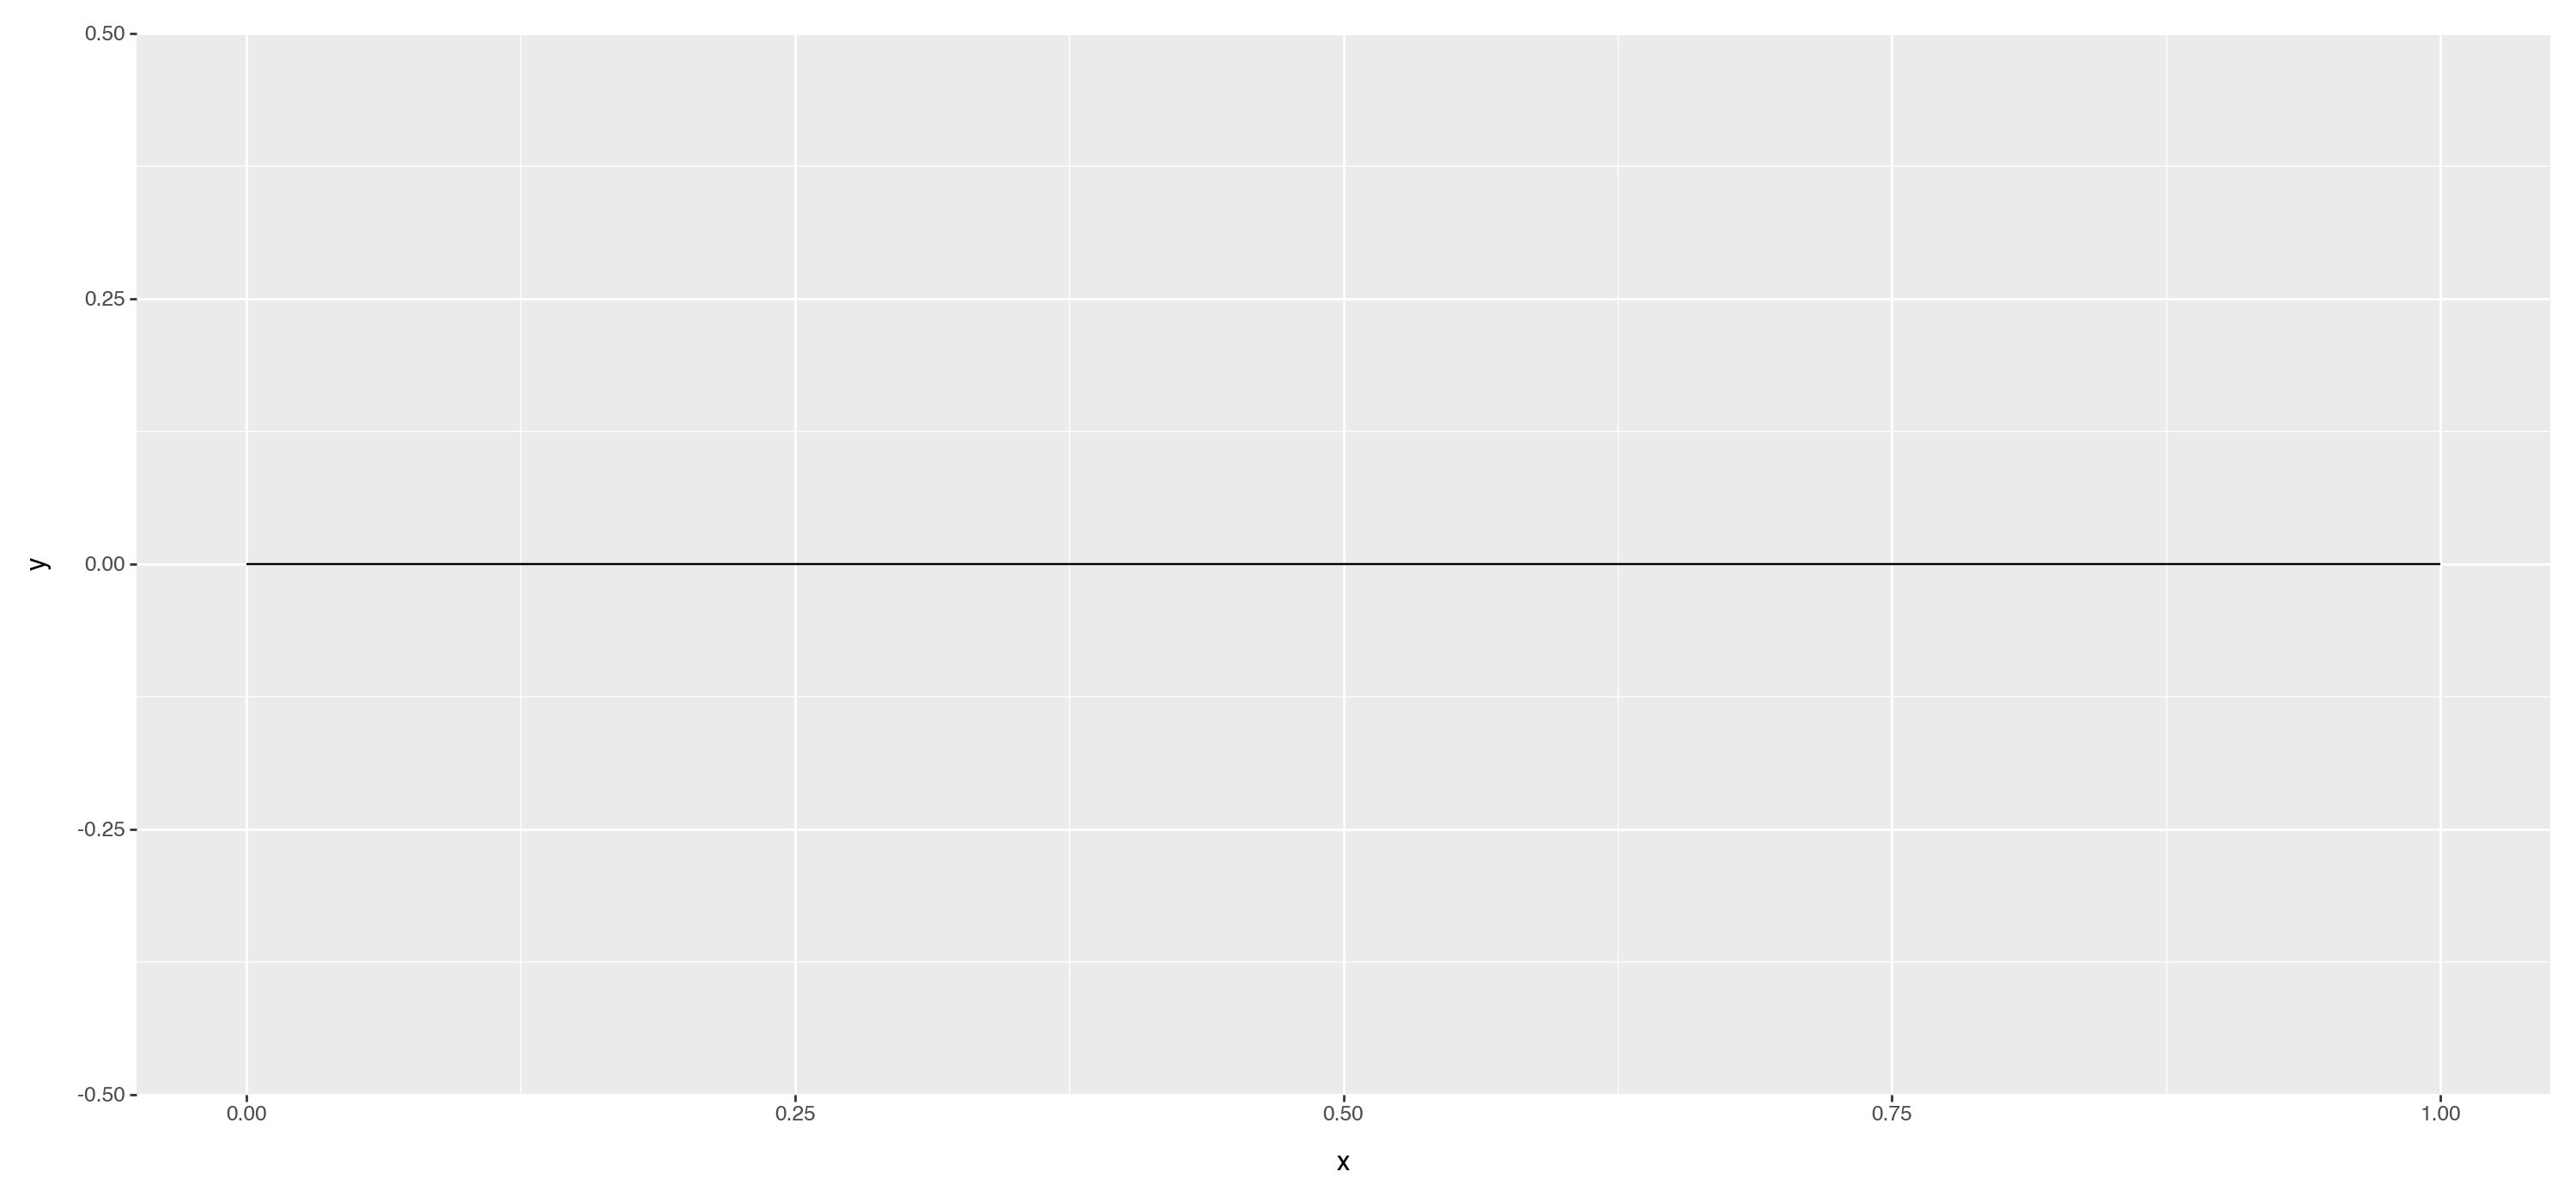

In [143]:
pred = DataFrame({'x': Xt['x_1'], 'y': lasso.predict(Xt)})
p = ggplot(pred) + geom_line((aes(x='x', y='y')))
p

## 7.4 Leverage of different points (<font color='red'>3p+2p</font>)

This exercise illustrates the concepts of leverage and how regularisation changes the leverage of individual data points. We use here a non-standard definition of leverage that is easy to interpret. Let $(\boldsymbol{x}_1, y_1),\ldots, (\boldsymbol{x}_n, y_n)$ be the set of training points.  Let $\vec{w}$ be the linear regression coefficients returned by the regression algorithm $\mathcal{R}$.  We define the leverage vector $\boldsymbol{\Delta a}(\boldsymbol{x}_i,\delta)$ of point $\vec{x}_i$ at error level $\delta$ the change of linear regression coefficients if we replace $y_i$ by $y_i+\delta$:
\begin{align*}
    \boldsymbol{\Delta a}(\boldsymbol{x}_i,\delta) = \mathcal{R}(\ldots, (\boldsymbol{x}_i,
    y_i+\delta),\ldots ) - \mathcal{R}(\ldots, (\boldsymbol{x}_i, y_i),\ldots
    )\enspace.
\end{align*}

For the comparison generate two data sets. The first should consist of $100$ points that are sampled uniformly from the range $[-1,1]\times[-1,1]$. The second consists of $100$ data points such that $x_i$ is sampled uniformly from $[-1,1]$ and $x_2=x_1+\varepsilon$ where $\varepsilon$ is uniformly sampled $[-0.05, 0.05]$. For clarity assume that $y\equiv 0$ over the region. 

* Fix ordinary least squares regression as $\mathcal{R}$. Compute leverage of all data points for the error level $\delta=0.1$. Draw data and highlight the points with high leverage. Since leverage consists of two components $\Delta a_1$ and $\Delta a_2$ order points first by the length of leverage vector
\begin{align*}
  || \boldsymbol{\Delta a}(\boldsymbol{x}_i,\delta)||=\sqrt{\Delta
        a_1^2(\boldsymbol{x}_i,\delta)+ \Delta a_2^2(\boldsymbol{x}_i,\delta)}
\end{align*}
and choose $10$ points with the highest length. Colour them red on the plot.  Secondly, compare how the length of leverage vectors depends on the dataset. For that draw the boxplots of the lengths for both data sets. What can you conclude?  (<font color='red'>1p</font>) 

* Fix ridge regression as $\mathcal{R}$ and study how the leverage of these 10 most influencial points changes when $\lambda\to\infty$. Pick $\lambda$ values so that there is something to see. Interpret results. Why is the leverage of a point dependant on its distance from the origin.  (<font color='red'>1p</font>)

* Fix LASSO regression as $\mathcal{R}$ and study how the leverage of these 10 most influencial points changes when $\lambda\to\infty$. Pick $\lambda$ values so that there is something to see. Interpret results. Which points have roughly the same leverage?  (<font color='red'>1p</font>) 

**Bonus:** You can get two extra points if you can use `keras` gradient tape to compute leverege defined as the length of a gradient vector
\begin{align*}
    \boldsymbol{\nabla a}(\boldsymbol{x}_i) = \frac{\partial \mathcal{R}\bigl(\boldsymbol{x}_1,
    y_1),\ldots, (\boldsymbol{x}_n,
    y_n)\bigr)}{\partial y_i}\enspace.
\end{align*}
and complete one of the subexercise.  (<font color='red'>2p</font>)
